In [214]:
# Import necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from evaluation import evaluate_classification
from sklearn.model_selection import cross_val_score
import pickle


Ensure to load path to train and validation files properly.

In [215]:
# Load data
def load_data(train_path, validation_path):
    df_train = pd.read_csv(train_path)
    df_validation = pd.read_csv(validation_path)

    return df_train, df_validation

In [216]:
df_train, df_validation = load_data("wine_classification/train.csv", "wine_classification/wine-test-set.csv")

In [217]:
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.8,0.770,0.00,1.8,0.066,34.0,52.0,0.99760,3.62,0.68,9.9,5
1,7.3,0.580,0.30,2.4,0.074,15.0,55.0,0.99680,3.46,0.59,10.2,5
2,9.8,0.250,0.49,2.7,0.088,15.0,33.0,0.99820,3.42,0.90,10.0,6
3,11.4,0.625,0.66,6.2,0.088,6.0,24.0,0.99880,3.11,0.99,13.3,6
4,7.1,0.720,0.00,1.8,0.123,6.0,14.0,0.99627,3.45,0.58,9.8,5


In [218]:
df_validation.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.4,0.37,0.25,1.9,0.074,21.0,49.0,0.9974,3.57,0.62,9.8,6
1,12.5,0.28,0.54,2.3,0.082,12.0,29.0,0.9997,3.11,1.36,9.8,7
2,11.5,0.31,0.51,2.2,0.079,14.0,28.0,0.9982,3.03,0.93,9.8,6
3,7.9,0.50,0.33,2.0,0.084,15.0,143.0,0.9968,3.20,0.55,9.5,5
4,9.8,0.51,0.19,3.2,0.081,8.0,30.0,0.9984,3.23,0.58,10.5,6


In [219]:
df_train.shape

(959, 12)

In [220]:
df_validation.shape

(320, 12)

In [221]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         959 non-null    float64
 1   volatile acidity      959 non-null    float64
 2   citric acid           959 non-null    float64
 3   residual sugar        959 non-null    float64
 4   chlorides             959 non-null    float64
 5   free sulfur dioxide   959 non-null    float64
 6   total sulfur dioxide  959 non-null    float64
 7   density               959 non-null    float64
 8   pH                    959 non-null    float64
 9   sulphates             959 non-null    float64
 10  alcohol               959 non-null    float64
 11  quality               959 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 90.0 KB


In [222]:
df_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [223]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         320 non-null    float64
 1   volatile acidity      320 non-null    float64
 2   citric acid           320 non-null    float64
 3   residual sugar        320 non-null    float64
 4   chlorides             320 non-null    float64
 5   free sulfur dioxide   320 non-null    float64
 6   total sulfur dioxide  320 non-null    float64
 7   density               320 non-null    float64
 8   pH                    320 non-null    float64
 9   sulphates             320 non-null    float64
 10  alcohol               320 non-null    float64
 11  quality               320 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 30.1 KB


In [224]:
print(f"Train:\n{df_train.isnull().sum()}\n\nValidation:\n{df_validation.isnull().sum()}")

Train:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Validation:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [225]:
print(f"Train:\n{df_train.duplicated().sum()}\n\nValidation:\n{df_validation.duplicated().sum()}")

Train:
102

Validation:
9


Since, duplicate rows are present. We have to drop them so model learns from unique data.

In [226]:
df_train = df_train.drop_duplicates()
df_validation = df_validation.drop_duplicates()

In [227]:
# After removal
print(f"Train:\n{df_train.duplicated().sum()}\n\nValidation:\n{df_validation.duplicated().sum()}")

Train:
0

Validation:
0


Since, all feature are numeric. No need of encoding of any sorts.

# EDA

Visualization

In [228]:
# Function for Histplot
def hist_plot(df, data):
    print(f"Histplots for {data} data:\n")
    
    for i in df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[i], kde = True)
        plt.title(f"Histogram of {i}")
        plt.xlabel(i)
        plt.ylabel("Count")
        plt.show()

In [229]:
# Function for boxplot
def box_plot(df, data):
    print(f"Boxplots for {data} data:\n")

    for i in df.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(df[i])
        plt.title(f"Boxplot of {i}")
        plt.xlabel(i)
        plt.ylabel("Count")
        plt.show()

In [230]:
# Heat Map
def heatmap_all(df, data):
    print(f"Heatmap for {data} data:\n")
    
    plt.figure(figsize = (12, 8))
    sns.heatmap(df.corr(), annot = True)
    plt.show()

Histplots for Train data:



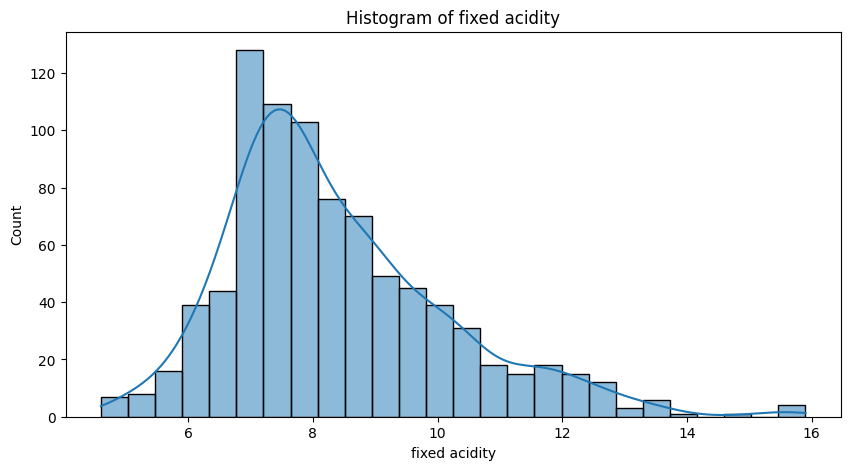

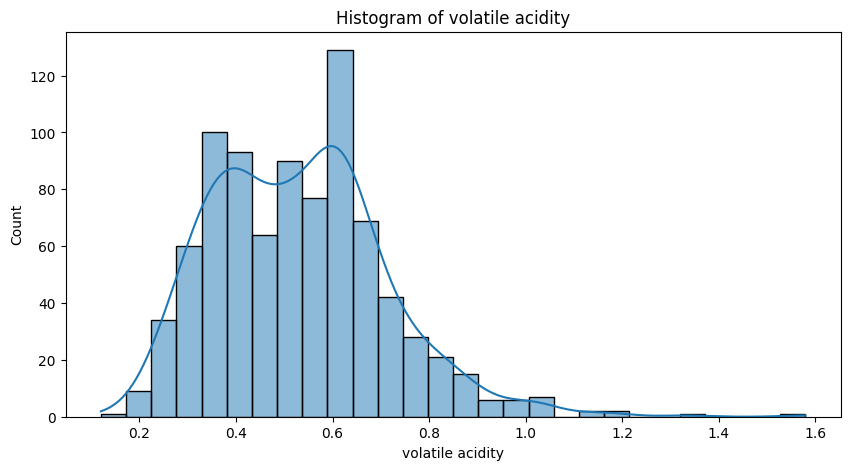

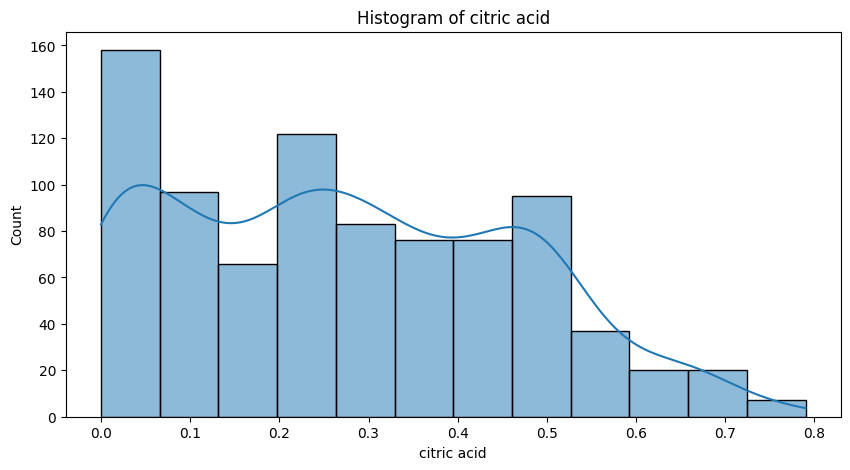

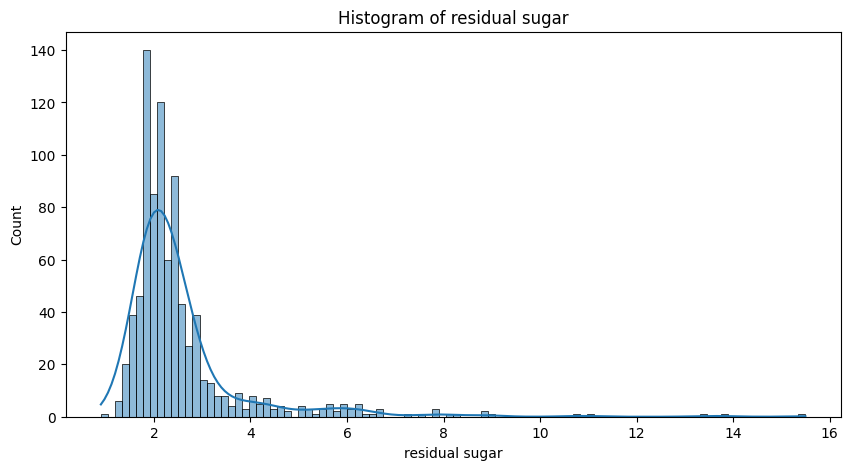

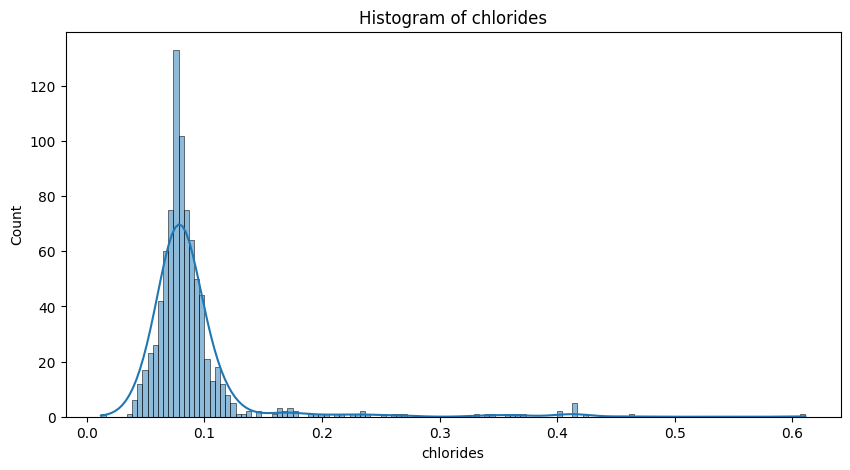

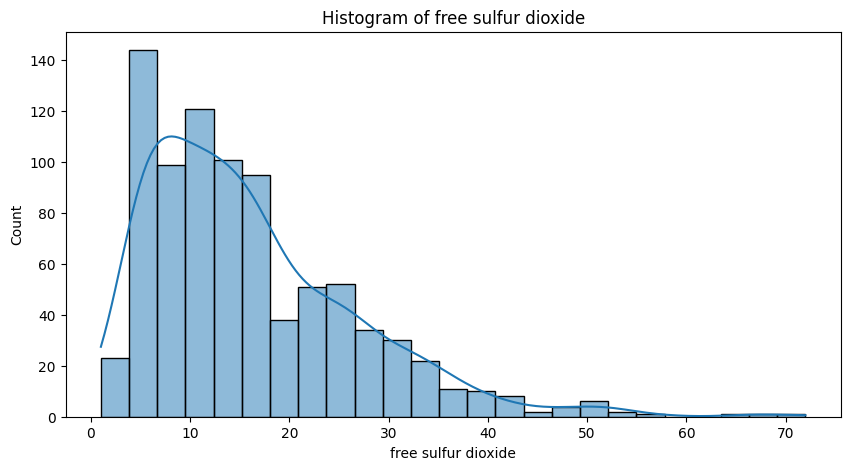

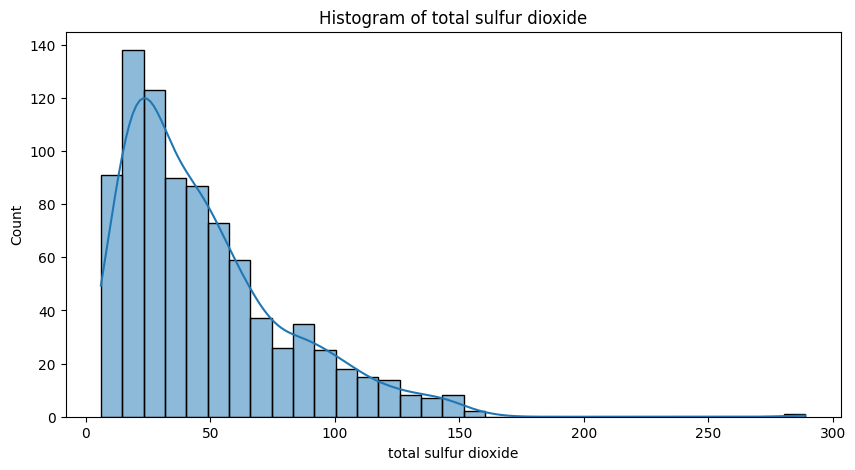

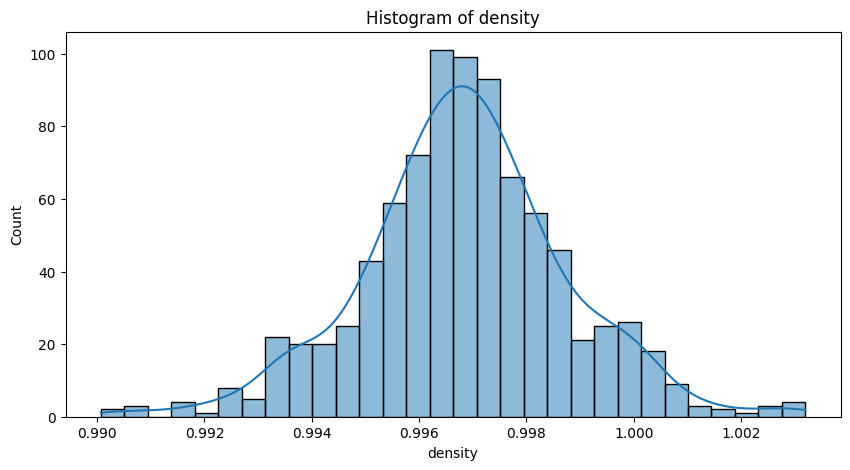

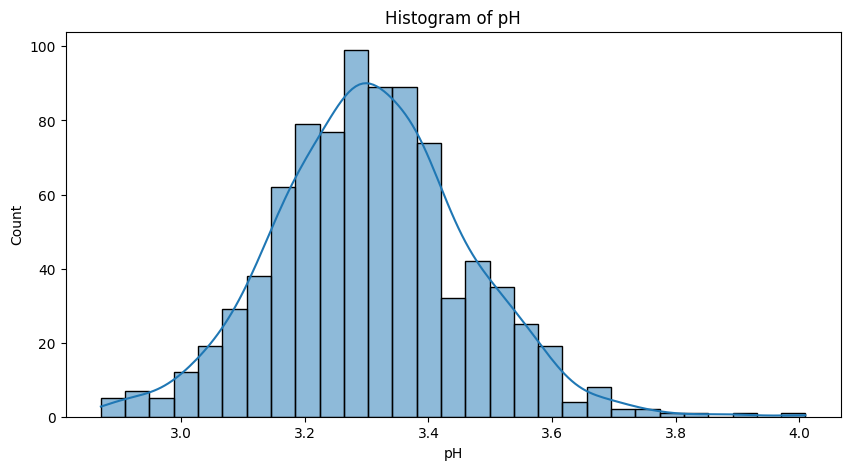

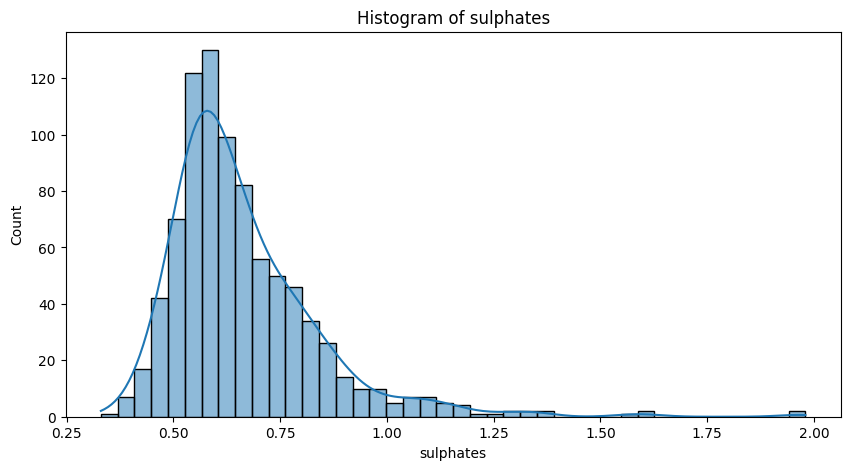

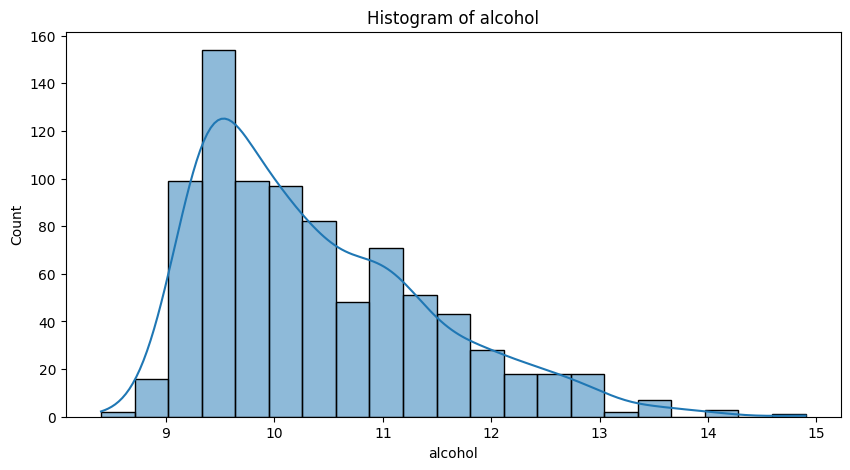

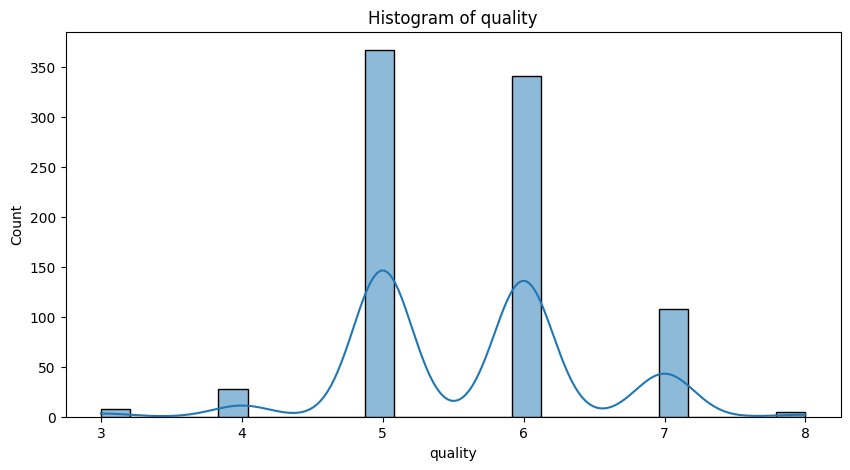

In [231]:
# Uncollapse to see visualized features
hist_plot(df_train, "Train")

Histplots for Validation data:



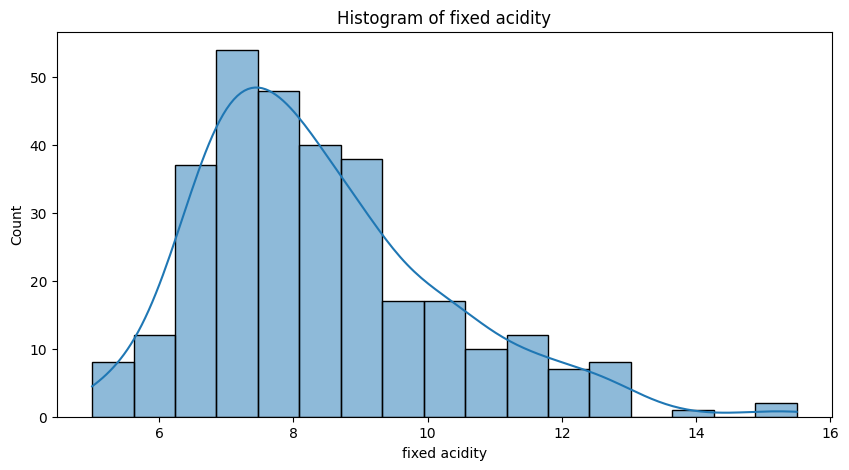

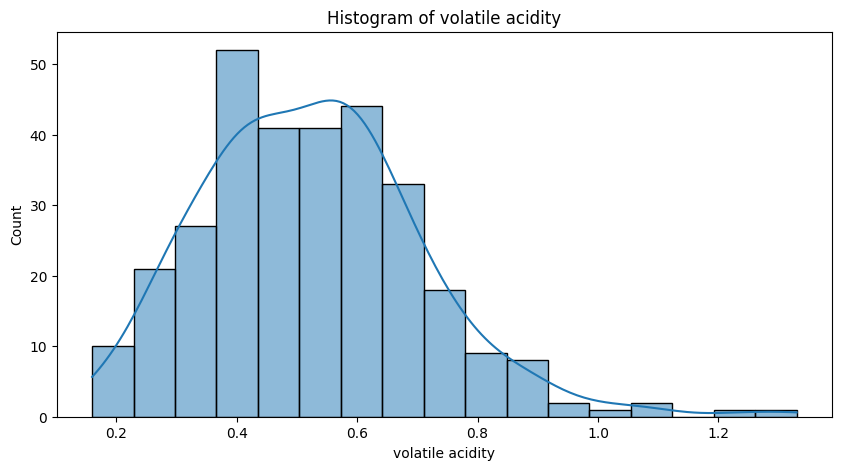

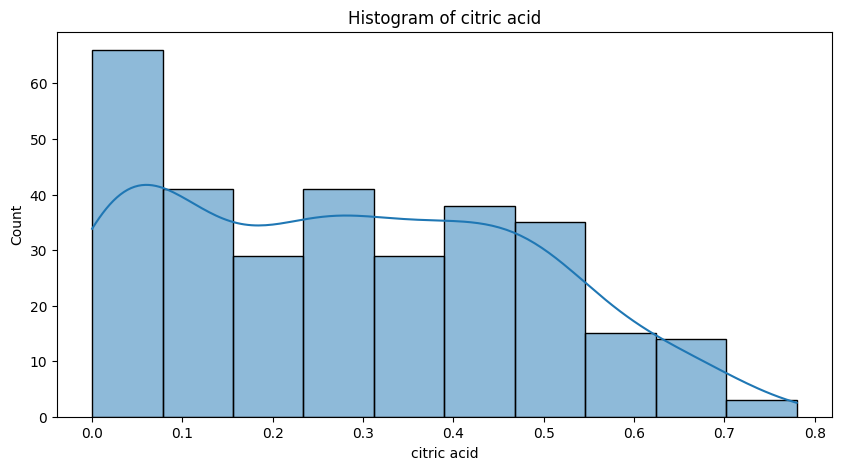

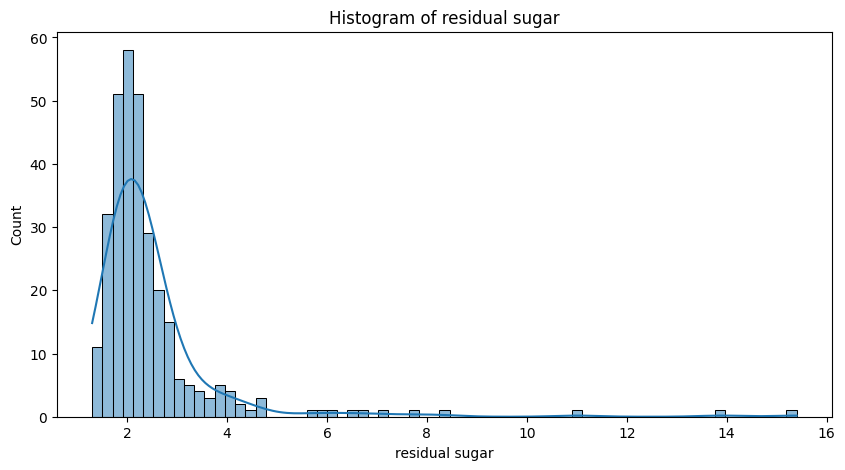

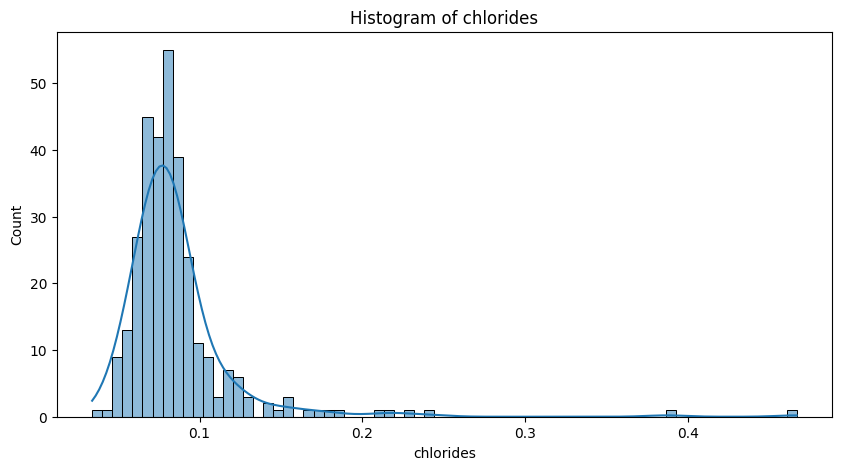

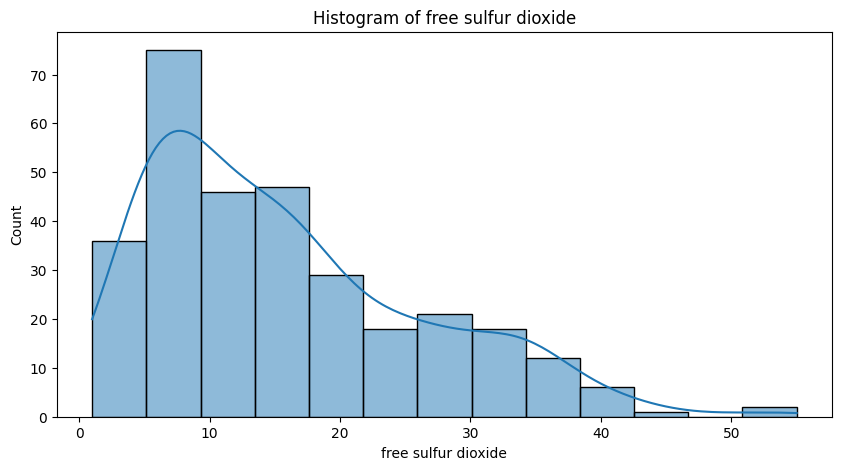

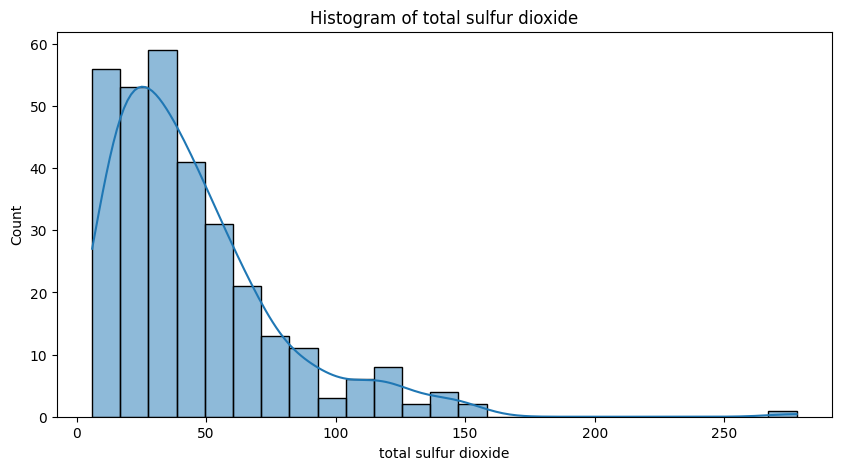

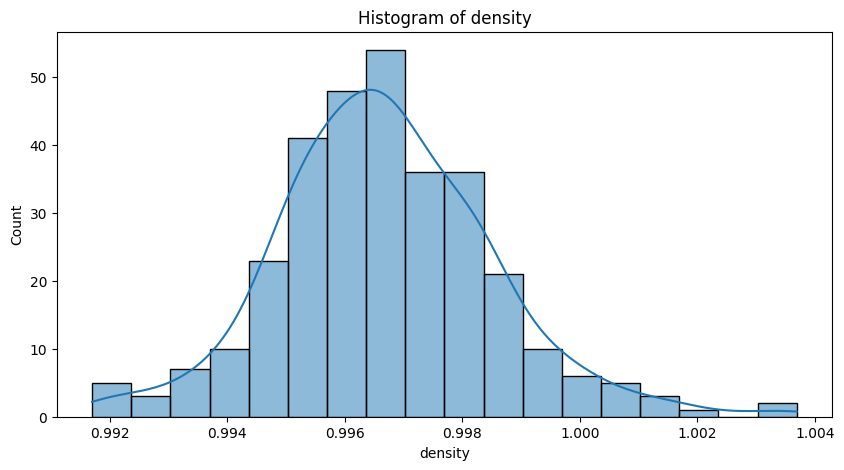

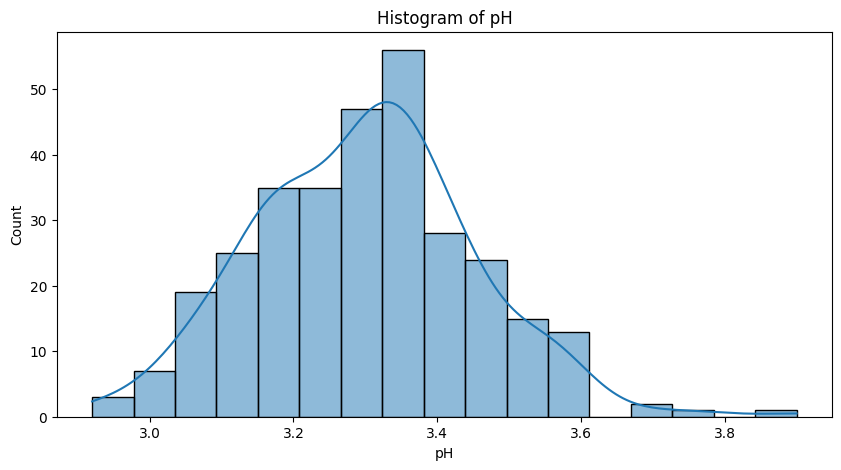

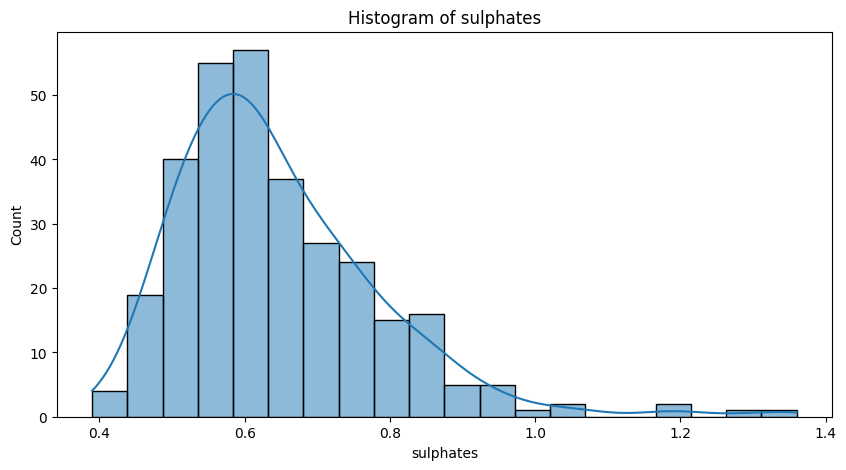

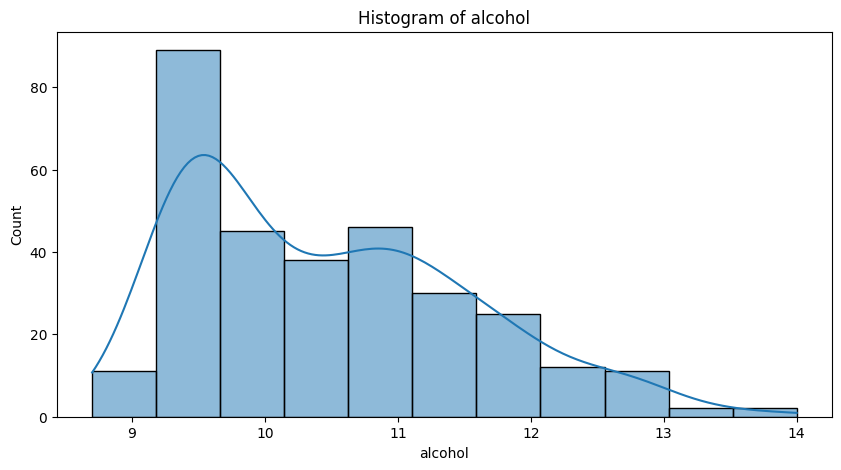

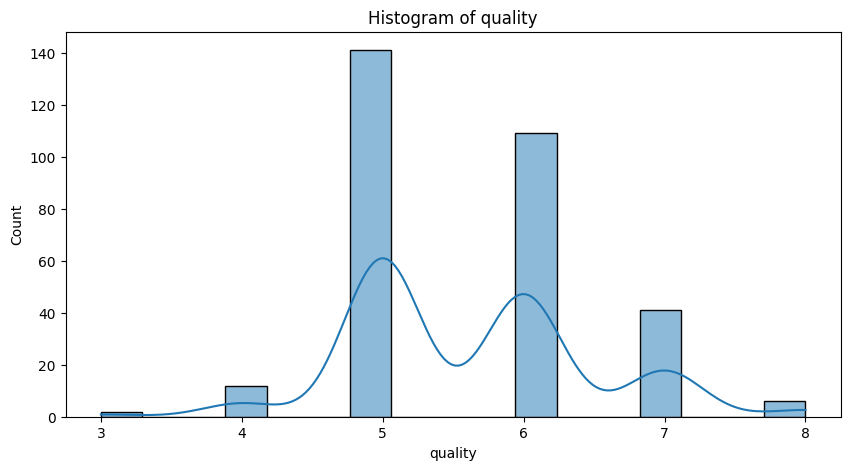

In [232]:
hist_plot(df_validation, "Validation")

Boxplots for Train data:



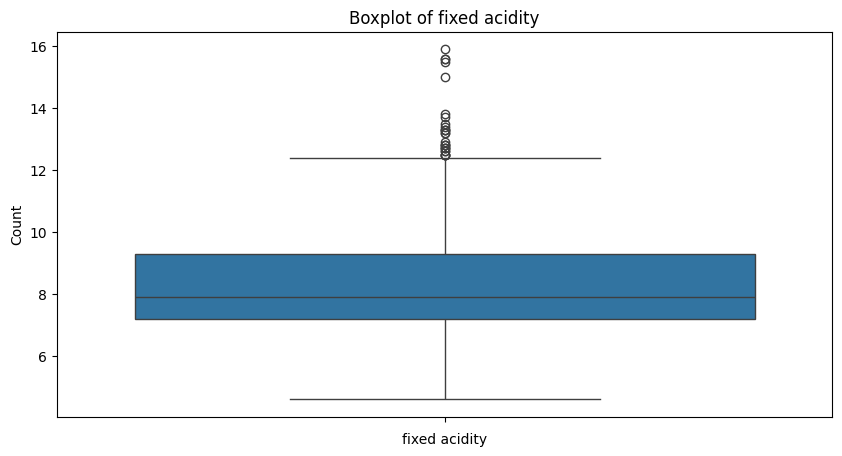

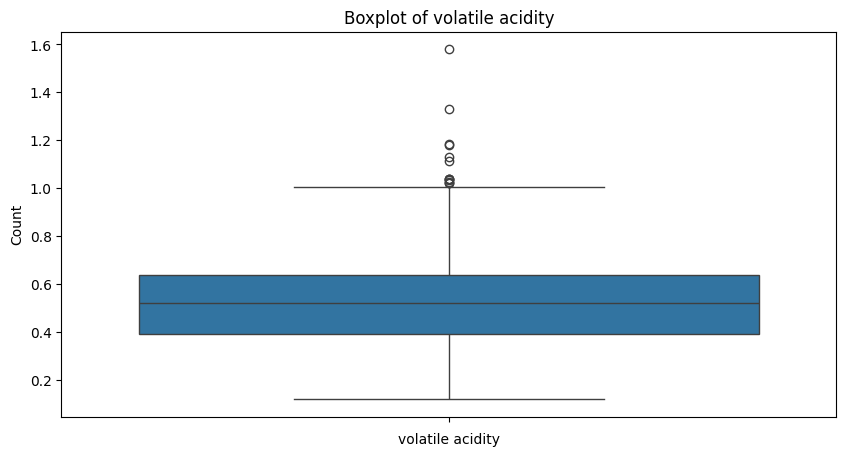

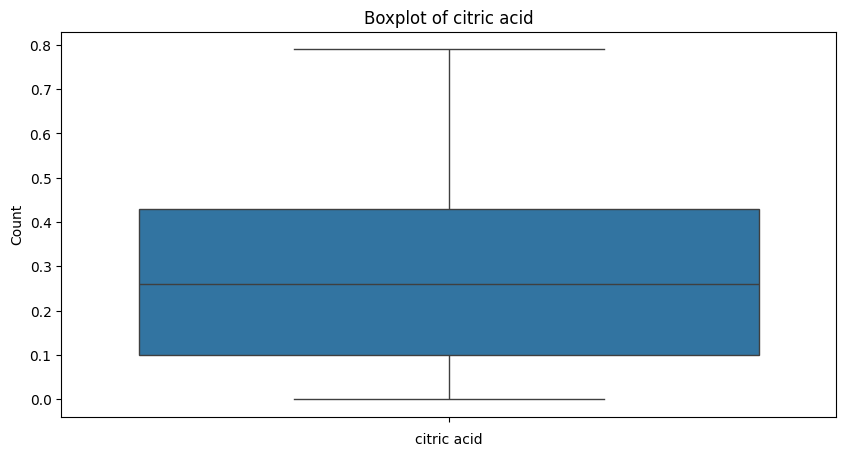

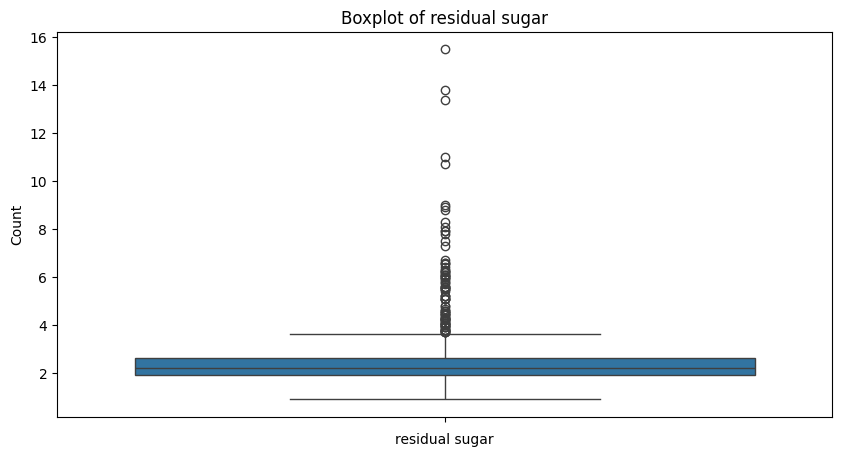

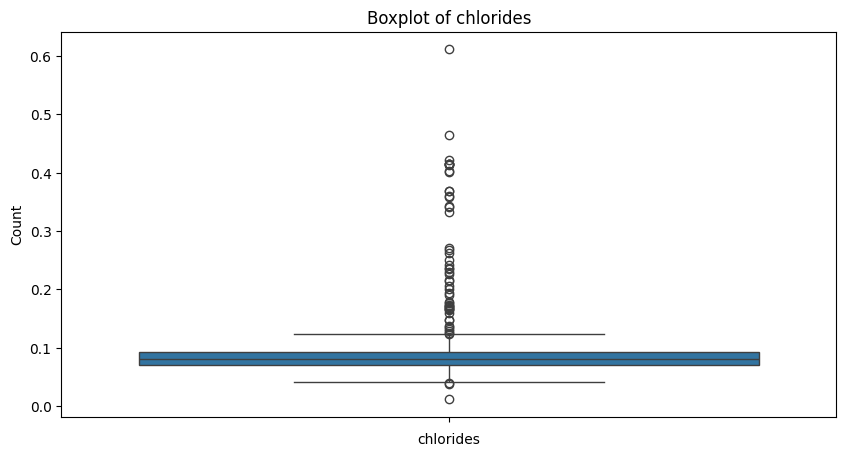

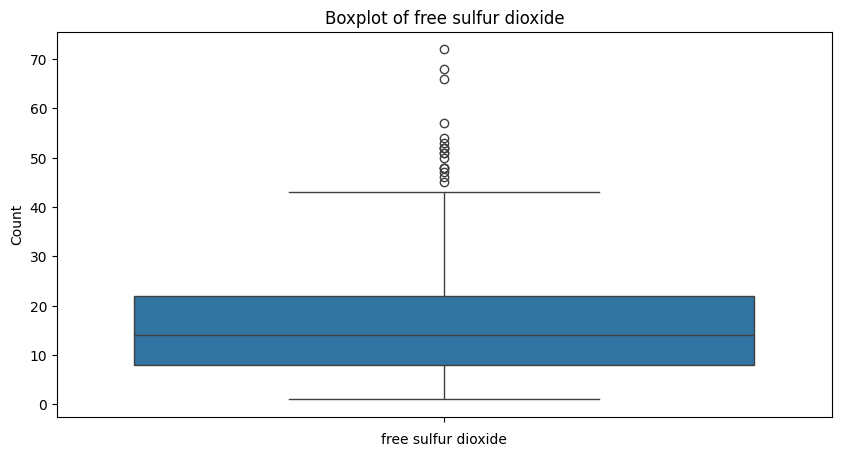

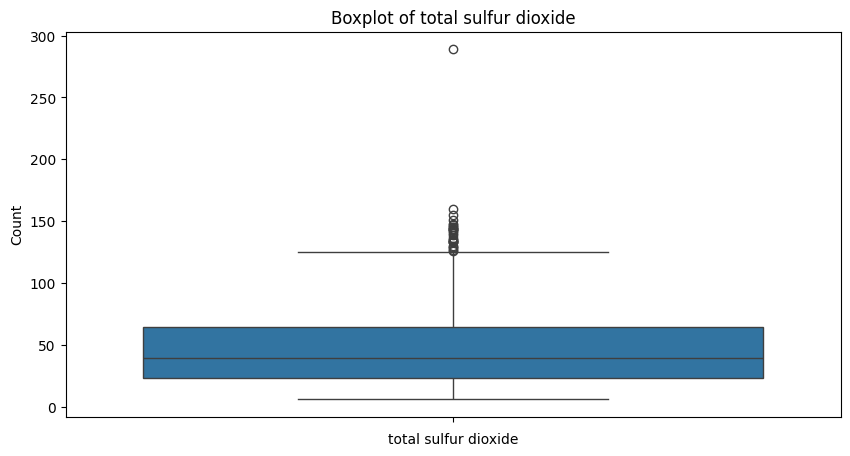

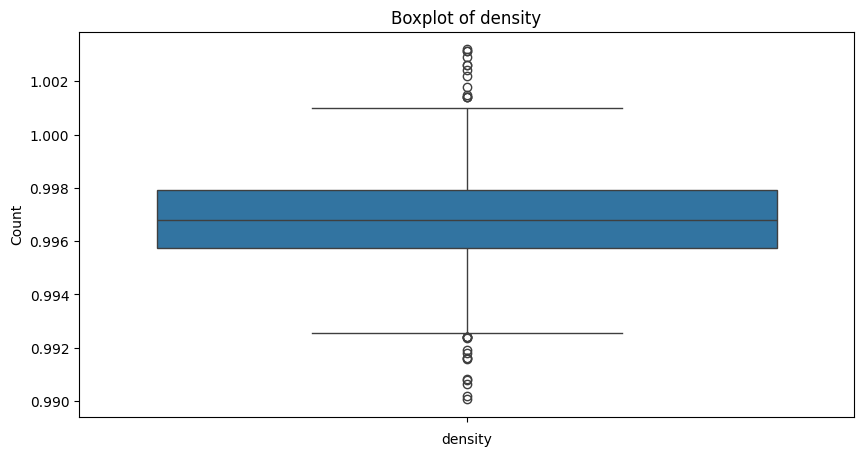

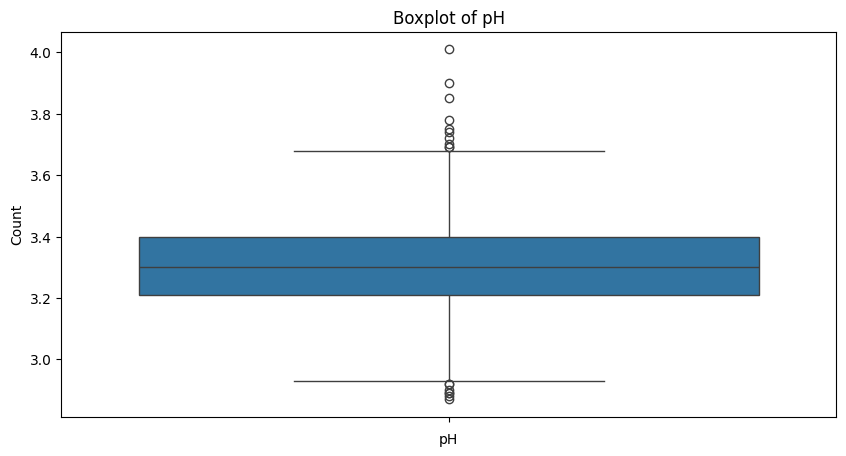

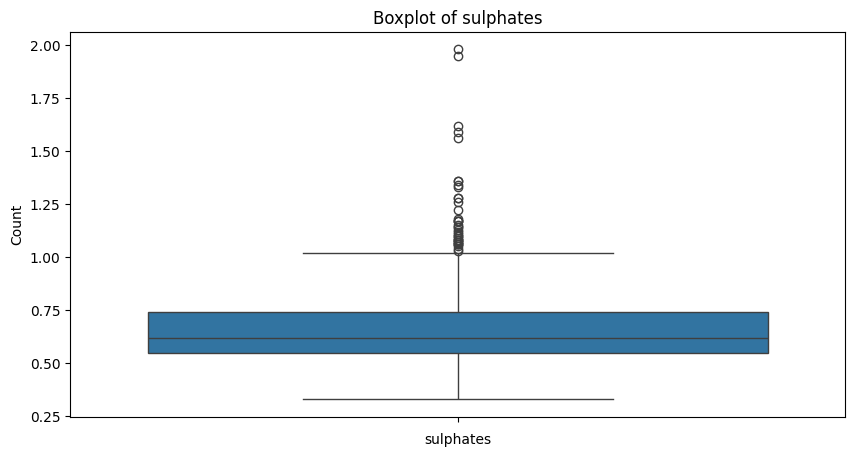

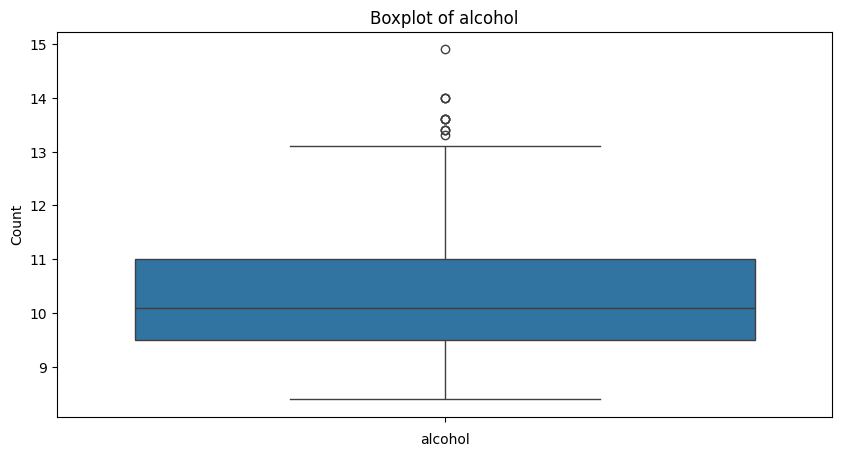

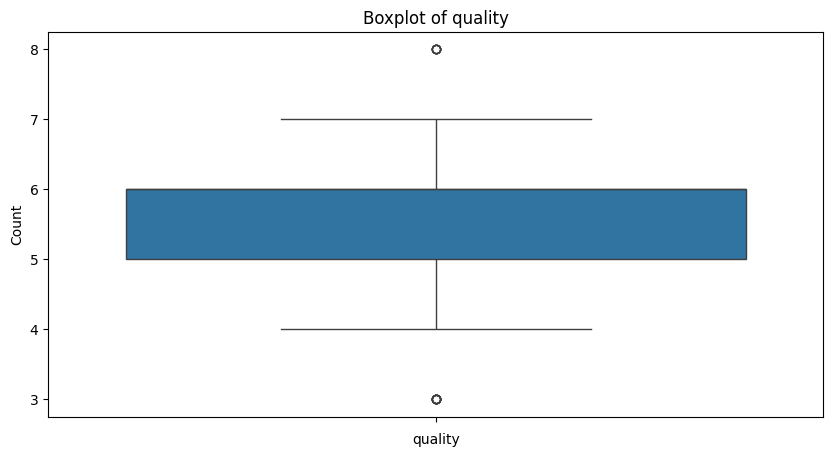

In [233]:
box_plot(df_train, "Train")

Boxplots for Validation data:



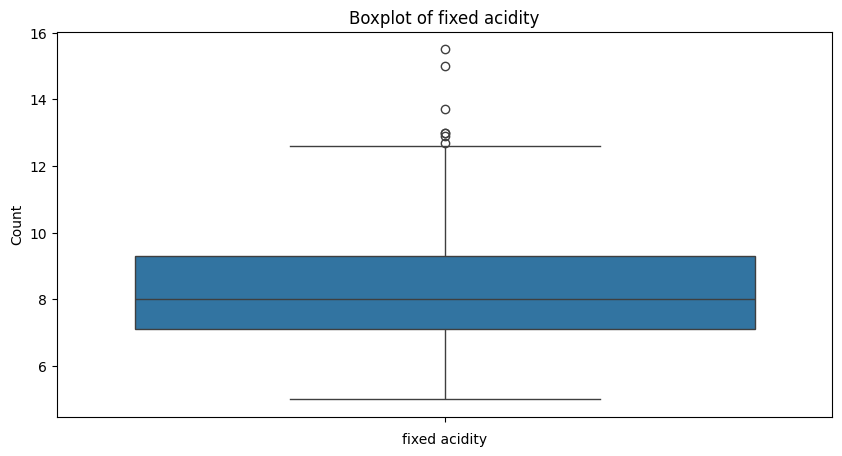

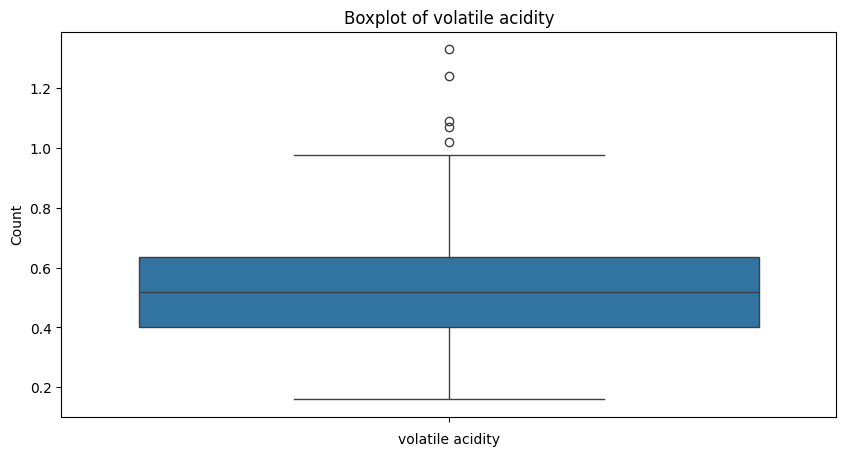

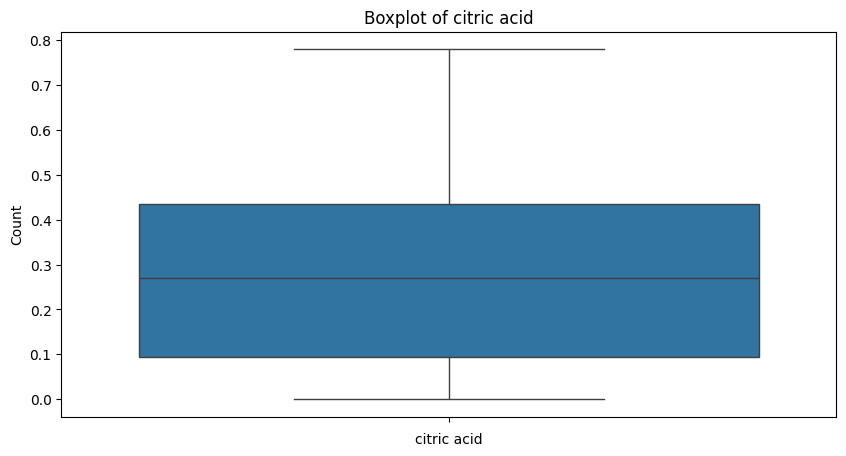

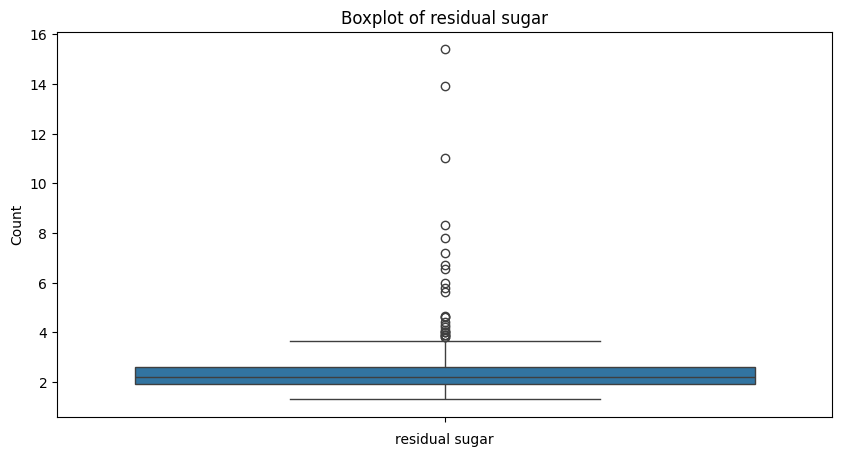

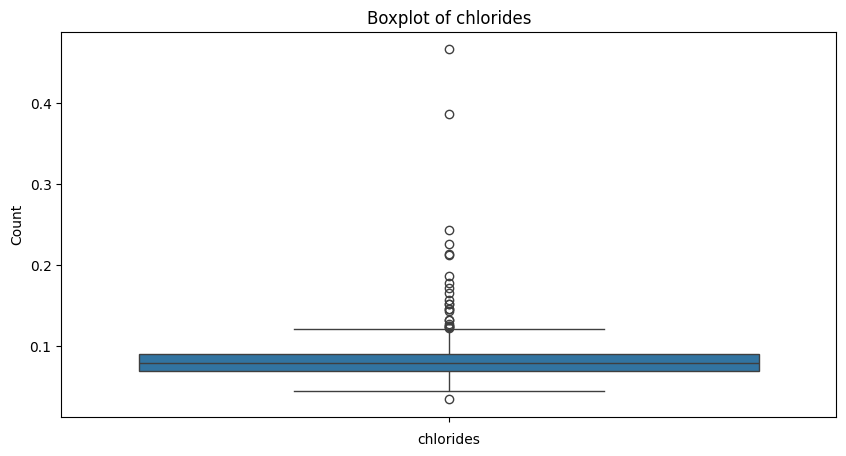

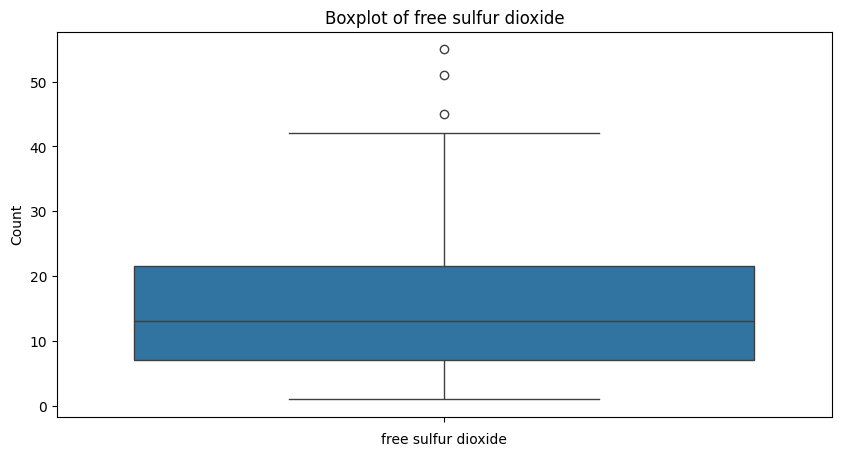

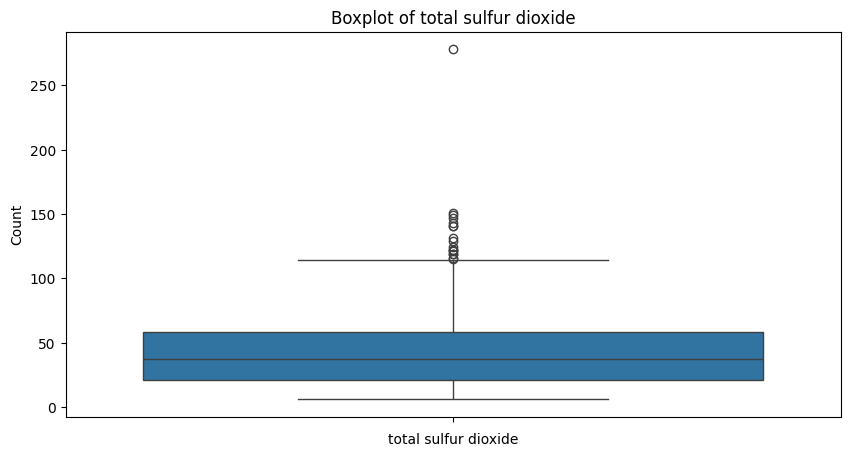

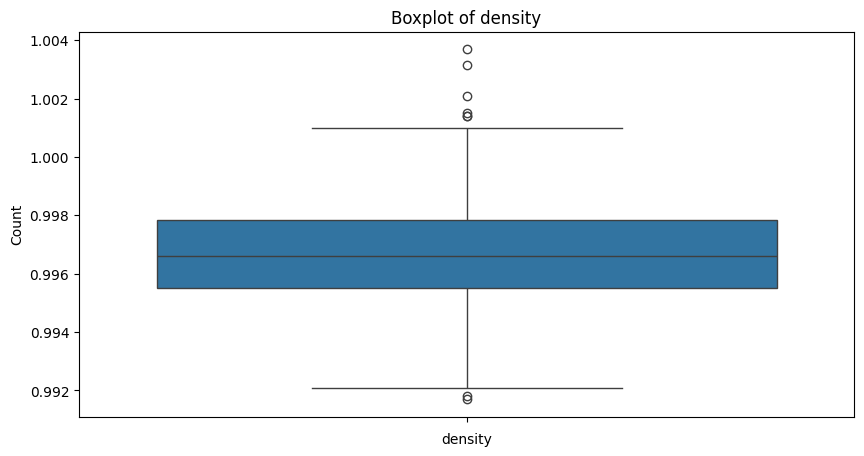

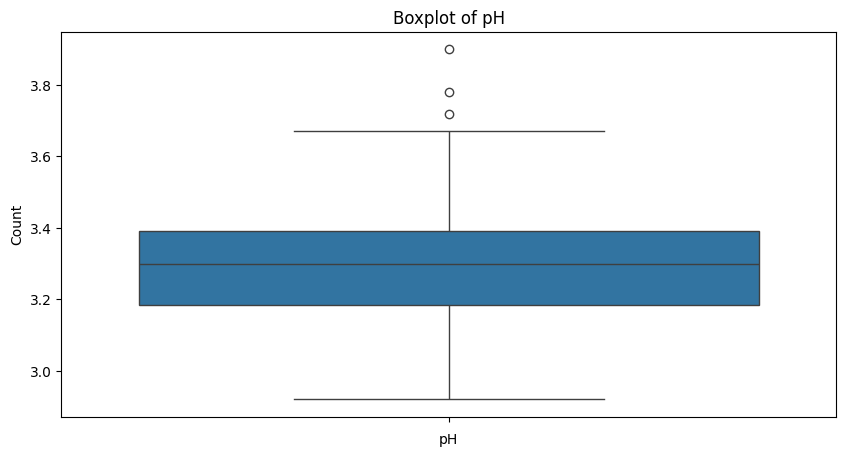

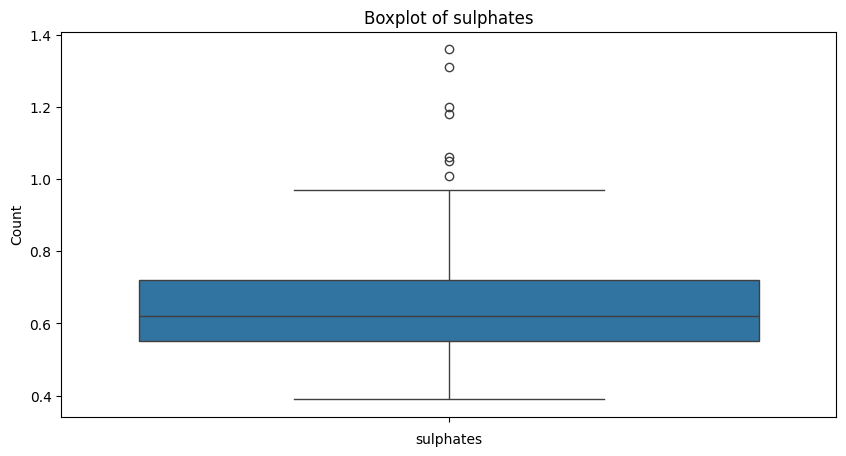

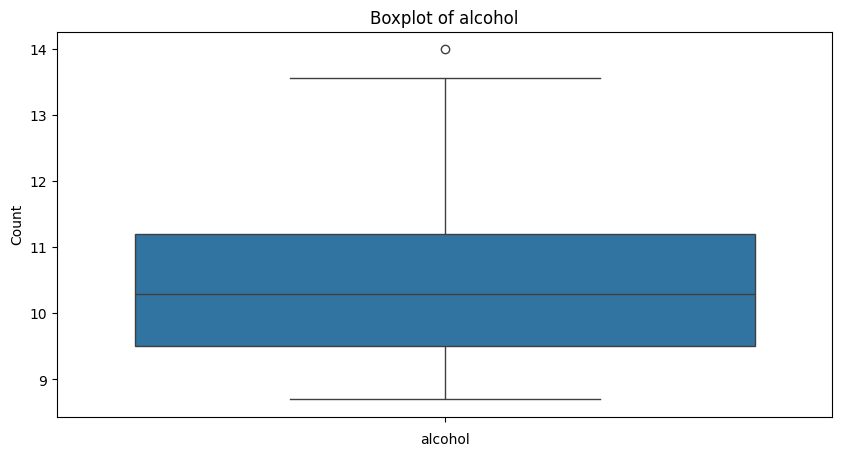

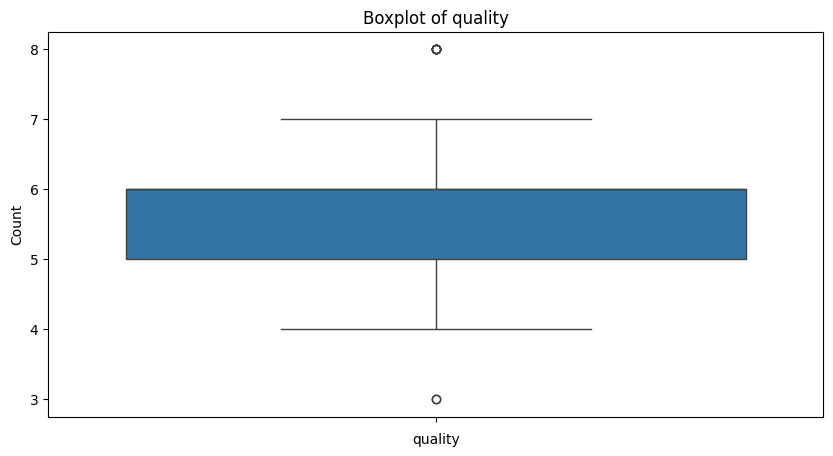

In [234]:
box_plot(df_validation, "Validation")

Heatmap for Train data:



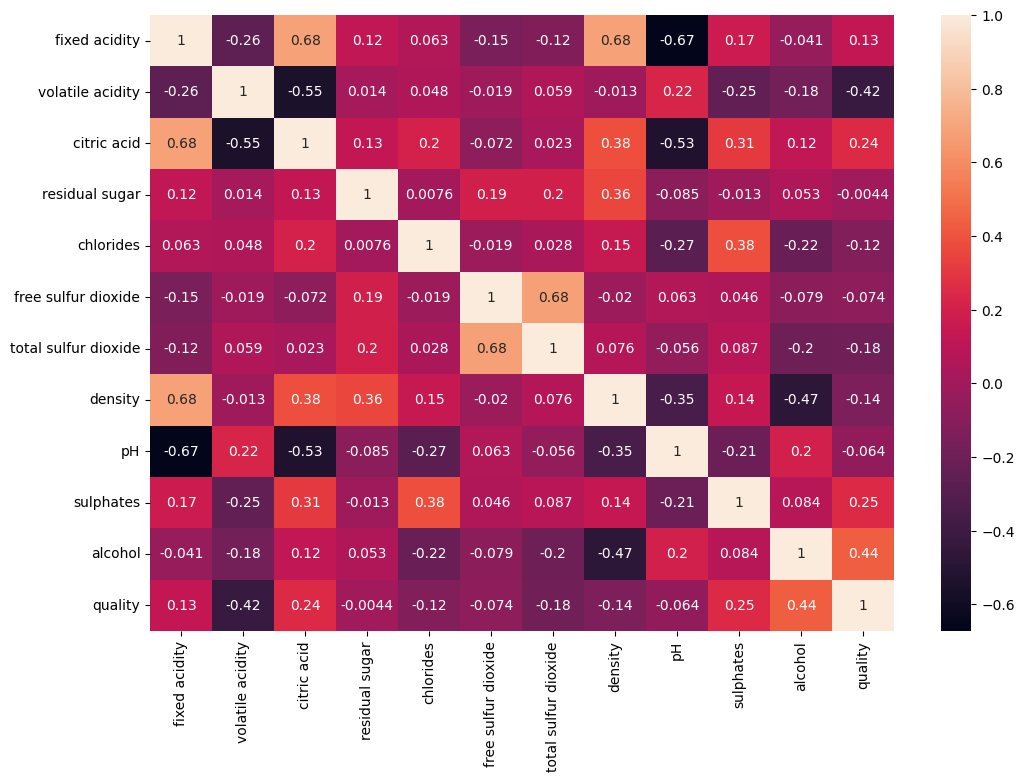

In [235]:
heatmap_all(df_train, "Train")

Heatmap for Validation data:



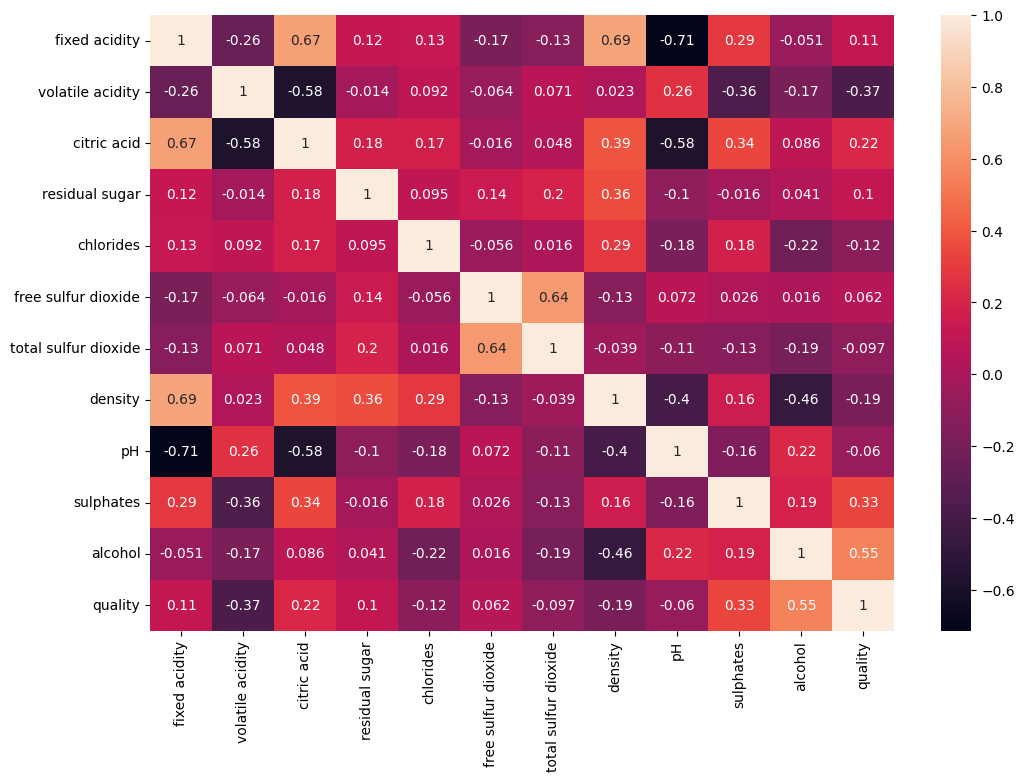

In [236]:
heatmap_all(df_validation, "Validation")

In [237]:
# Calculate skewness of all features in a dataframe
def skew_calc(df):
    i = 1
    skew_vals_rev = {df[name].skew():name for name in df}
    skew_vals_rev_sorted = dict(sorted(skew_vals_rev.items()))
    skew_vals = {value:key for key, value in skew_vals_rev_sorted.items()}
    print(f"Skewness of all features in given dataframe: ")
    for key, value in skew_vals.items():
        print(f"{i}. {key} = {value}")
        print('-' * 50)
        i += 1

In [238]:
# Skew calculation
def skew_train():
    print("For train: ")
    skew_calc(df_train)

In [239]:
def skew_valid():
    print("For validation: ")
    return skew_calc(df_validation)

In [240]:
skew_train()

For train: 
Skewness of all features in given dataframe: 
1. density = -0.012316871370226821
--------------------------------------------------
2. quality = 0.058736115011953936
--------------------------------------------------
3. pH = 0.21683580254171197
--------------------------------------------------
4. citric acid = 0.2919728356616264
--------------------------------------------------
5. volatile acidity = 0.7748796624262977
--------------------------------------------------
6. alcohol = 0.9686141642984372
--------------------------------------------------
7. fixed acidity = 0.9933904045160031
--------------------------------------------------
8. free sulfur dioxide = 1.3597552737819316
--------------------------------------------------
9. total sulfur dioxide = 1.4507849842937928
--------------------------------------------------
10. sulphates = 2.2511677971515525
--------------------------------------------------
11. residual sugar = 4.066864722368144
-------------------------

In [241]:
skew_valid()

For validation: 
Skewness of all features in given dataframe: 
1. citric acid = 0.26245831083497834
--------------------------------------------------
2. pH = 0.2666234244208462
--------------------------------------------------
3. density = 0.3642861084323793
--------------------------------------------------
4. quality = 0.380944682336351
--------------------------------------------------
5. alcohol = 0.6879039451765229
--------------------------------------------------
6. volatile acidity = 0.7322825600057715
--------------------------------------------------
7. fixed acidity = 0.9300211458871732
--------------------------------------------------
8. free sulfur dioxide = 0.9469408793450074
--------------------------------------------------
9. sulphates = 1.489677366578799
--------------------------------------------------
10. total sulfur dioxide = 2.06842276817967
--------------------------------------------------
11. residual sugar = 5.347687210795412
-----------------------------

In [242]:
# List of high skew features
def skewed_list(df):
    skewed_list = [name for name in df if df[name].skew() > 1 or df[name].skew() < -1]
    return skewed_list

In [243]:
skewed_list(df_train)

['residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'sulphates']

In [244]:
skewed_list(df_validation)

['residual sugar', 'chlorides', 'total sulfur dioxide', 'sulphates']

In [245]:
# Log Transformation 

# df_train['residual sugar'] = np.log1p(df_train['residual sugar'])
# df_train['chlorides'] = np.log1p(df_train['chlorides'])
# df_train['total sulfur dioxide'] = np.log1p(df_train['total sulfur dioxide'])
# df_train['sulphates'] = np.log1p(df_train['sulphates'])
# df_train['free sulfur dioxide'] = np.log1p(df_train['free sulfur dioxide'])

# df_validation['residual sugar'] = np.log1p(df_validation['residual sugar'])
# df_validation['chlorides'] = np.log1p(df_validation['chlorides'])
# df_validation['total sulfur dioxide'] = np.log1p(df_validation['total sulfur dioxide'])
# df_validation['sulphates'] = np.log1p(df_validation['sulphates'])

After testing some methods, not using log transformation provided better results.


In [246]:
skew_train()

For train: 
Skewness of all features in given dataframe: 
1. density = -0.012316871370226821
--------------------------------------------------
2. quality = 0.058736115011953936
--------------------------------------------------
3. pH = 0.21683580254171197
--------------------------------------------------
4. citric acid = 0.2919728356616264
--------------------------------------------------
5. volatile acidity = 0.7748796624262977
--------------------------------------------------
6. alcohol = 0.9686141642984372
--------------------------------------------------
7. fixed acidity = 0.9933904045160031
--------------------------------------------------
8. free sulfur dioxide = 1.3597552737819316
--------------------------------------------------
9. total sulfur dioxide = 1.4507849842937928
--------------------------------------------------
10. sulphates = 2.2511677971515525
--------------------------------------------------
11. residual sugar = 4.066864722368144
-------------------------

In [247]:
skew_valid()

For validation: 
Skewness of all features in given dataframe: 
1. citric acid = 0.26245831083497834
--------------------------------------------------
2. pH = 0.2666234244208462
--------------------------------------------------
3. density = 0.3642861084323793
--------------------------------------------------
4. quality = 0.380944682336351
--------------------------------------------------
5. alcohol = 0.6879039451765229
--------------------------------------------------
6. volatile acidity = 0.7322825600057715
--------------------------------------------------
7. fixed acidity = 0.9300211458871732
--------------------------------------------------
8. free sulfur dioxide = 0.9469408793450074
--------------------------------------------------
9. sulphates = 1.489677366578799
--------------------------------------------------
10. total sulfur dioxide = 2.06842276817967
--------------------------------------------------
11. residual sugar = 5.347687210795412
-----------------------------

In [248]:
# Box Cox only works for positives, for training - On features with extreme skew

df_train['free sulfur dioxide'] = stats.boxcox(df_train['free sulfur dioxide'])[0]
df_train['chlorides'] = stats.boxcox(df_train['chlorides'])[0]
df_train['residual sugar'] = stats.boxcox(df_train['residual sugar'])[0]
df_train['sulphates'] = stats.boxcox(df_train['sulphates'])[0]
# df_train['total sulfur dioxide'] = stats.boxcox(df_train['total sulfur dioxide'])[0] # Remove if log is used as well

df_validation['chlorides'] = stats.boxcox(df_validation['chlorides'])[0]
df_validation['residual sugar'] = stats.boxcox(df_validation['residual sugar'])[0]
df_validation['sulphates'] = stats.boxcox(df_validation['sulphates'])[0]
# df_validation['total sulfur dioxide'] = stats.boxcox(df_validation['total sulfur dioxide'])[0] # Remove if log is used as well


# df_train = df_train.drop(['chlorides', 'residual sugar', 'sulphates', 'free sulfur dioxide'], axis = 1)
# df_validation = df_validation.drop(['chlorides', 'residual sugar', 'sulphates'], axis = 1)

In [249]:
skew_train()

For train: 
Skewness of all features in given dataframe: 
1. chlorides = -0.5727022306458655
--------------------------------------------------
2. residual sugar = -0.07236873177050579
--------------------------------------------------
3. sulphates = -0.020647361372827553
--------------------------------------------------
4. free sulfur dioxide = -0.01452041177767737
--------------------------------------------------
5. density = -0.012316871370226821
--------------------------------------------------
6. quality = 0.058736115011953936
--------------------------------------------------
7. pH = 0.21683580254171197
--------------------------------------------------
8. citric acid = 0.2919728356616264
--------------------------------------------------
9. volatile acidity = 0.7748796624262977
--------------------------------------------------
10. alcohol = 0.9686141642984372
--------------------------------------------------
11. fixed acidity = 0.9933904045160031
---------------------------

In [250]:
skew_valid()

For validation: 
Skewness of all features in given dataframe: 
1. chlorides = -0.16867227919882638
--------------------------------------------------
2. sulphates = 0.0018764908941139823
--------------------------------------------------
3. residual sugar = 0.009654626445514944
--------------------------------------------------
4. citric acid = 0.26245831083497834
--------------------------------------------------
5. pH = 0.2666234244208462
--------------------------------------------------
6. density = 0.3642861084323793
--------------------------------------------------
7. quality = 0.380944682336351
--------------------------------------------------
8. alcohol = 0.6879039451765229
--------------------------------------------------
9. volatile acidity = 0.7322825600057715
--------------------------------------------------
10. fixed acidity = 0.9300211458871732
--------------------------------------------------
11. free sulfur dioxide = 0.9469408793450074
-----------------------------

In [251]:
# Splitting data into X and y
def split_data(df_train, df_validation):
    X_train = df_train.drop("quality", axis = 1)
    y_train = df_train['quality']

    X_valid = df_validation.drop('quality', axis =1)
    y_valid = df_validation['quality']

    return X_train, y_train, X_valid, y_valid

In [252]:
X_train, y_train, X_valid, y_valid = split_data(df_train, df_validation)

In [253]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.8,0.770,0.00,0.424615,-6.031576,4.389029,52.0,0.99760,3.62,-0.476335,9.9
1,7.3,0.580,0.30,0.547091,-5.568864,3.199404,55.0,0.99680,3.46,-0.706818,10.2
2,9.8,0.250,0.49,0.586461,-4.918948,3.199404,33.0,0.99820,3.42,-0.111464,10.0
3,11.4,0.625,0.66,0.751927,-4.918948,1.998778,24.0,0.99880,3.11,-0.010104,13.3
4,7.1,0.720,0.00,0.424615,-3.818801,1.998778,14.0,0.99627,3.45,-0.736980,9.8


In [254]:
X_valid.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.4,0.37,0.25,0.413688,-11.226614,21.0,49.0,0.9974,3.57,-0.611631,9.8
1,12.5,0.28,0.54,0.477775,-10.096405,12.0,29.0,0.9997,3.11,0.265017,9.8
2,11.5,0.31,0.51,0.464445,-10.494210,14.0,28.0,0.9982,3.03,-0.075247,9.8
3,7.9,0.50,0.33,0.432717,-9.846525,15.0,143.0,0.9968,3.20,-0.816020,9.5
4,9.8,0.51,0.19,0.553481,-10.225831,8.0,30.0,0.9984,3.23,-0.722408,10.5


In [255]:
y_train.head()
y_train.value_counts(ascending=True)


quality
8      5
3      8
4     28
7    108
6    341
5    367
Name: count, dtype: int64

In [256]:
# Changing quality 3 to 4 to match with y_valid values
y_train = y_train.replace({3:4})

In [257]:
y_valid.head()
y_valid.value_counts(ascending=True)

quality
3      2
8      6
4     12
7     41
6    109
5    141
Name: count, dtype: int64

Histplots for Train data:



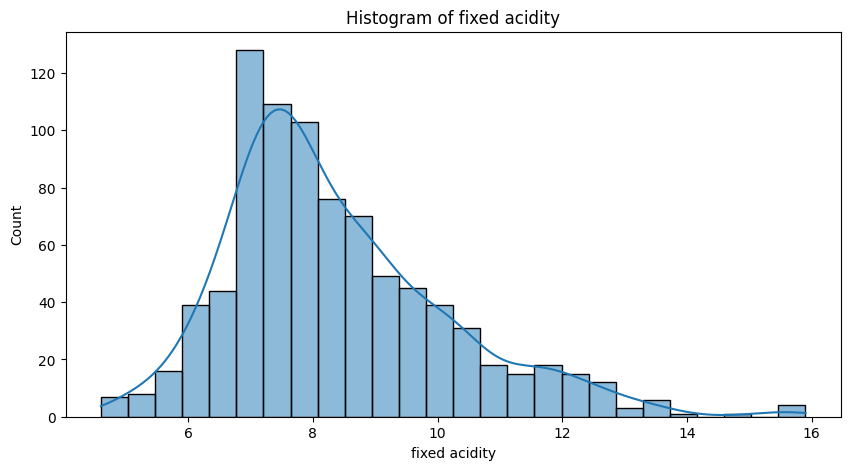

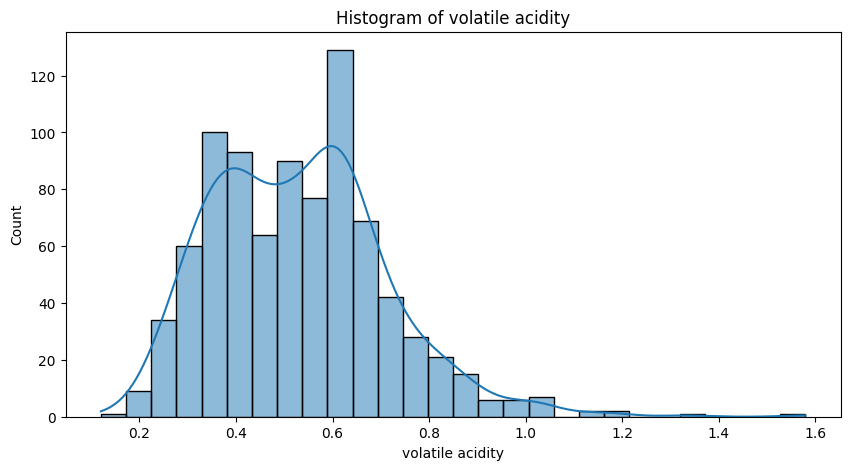

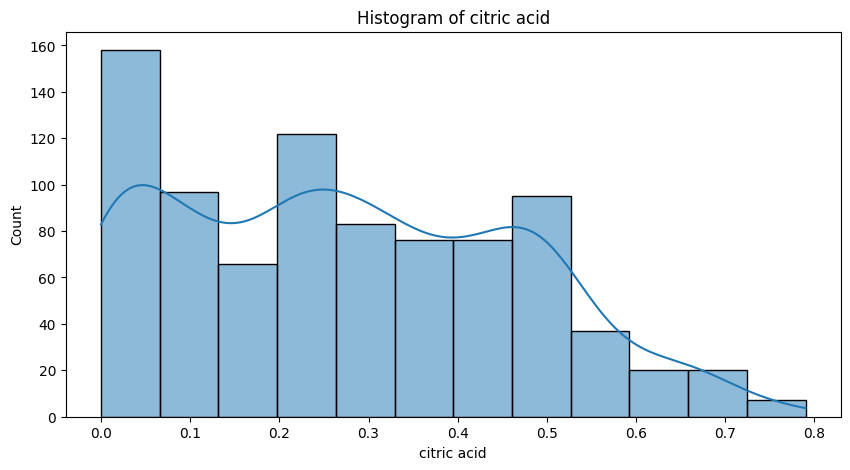

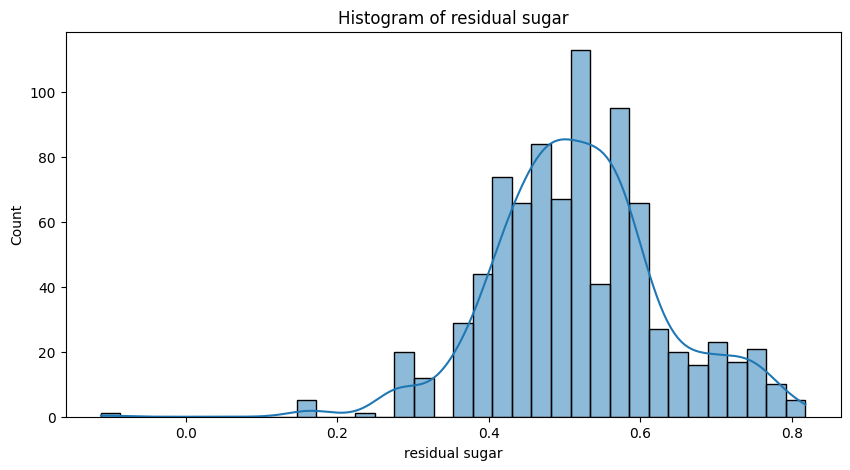

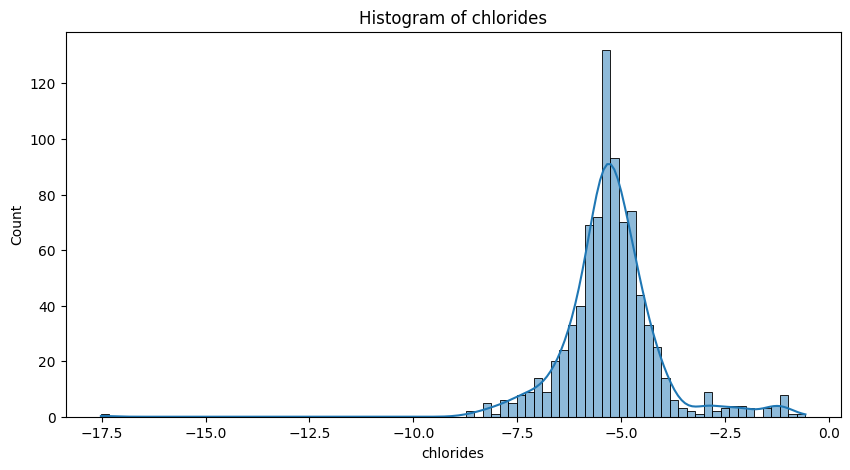

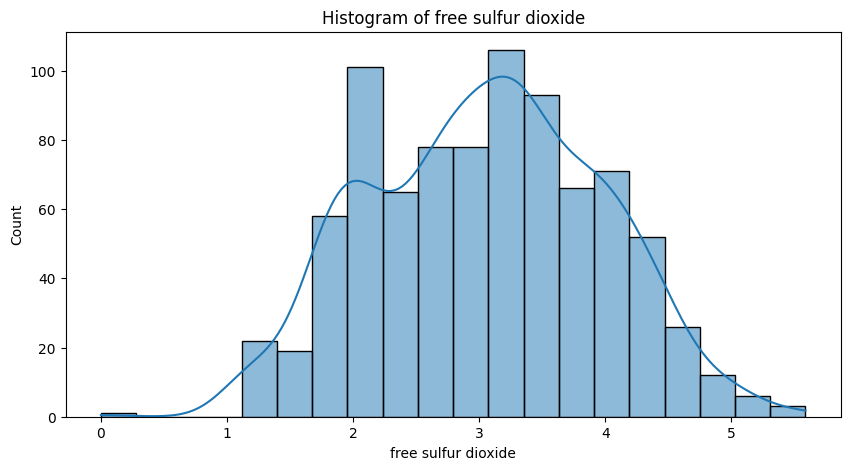

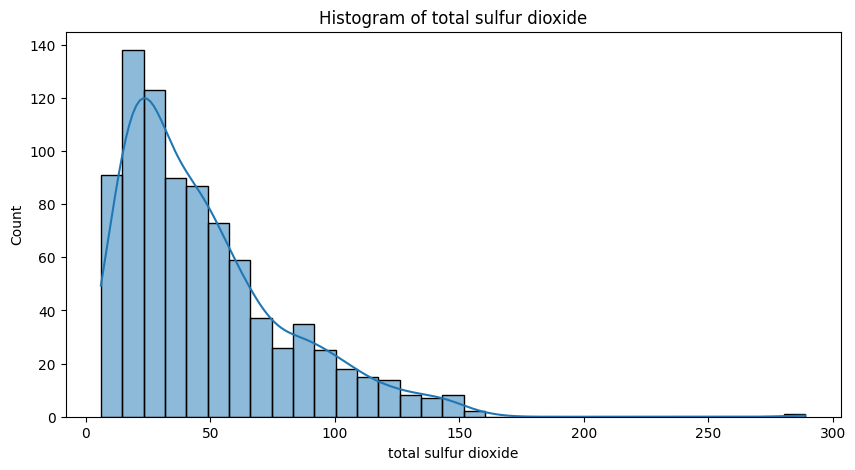

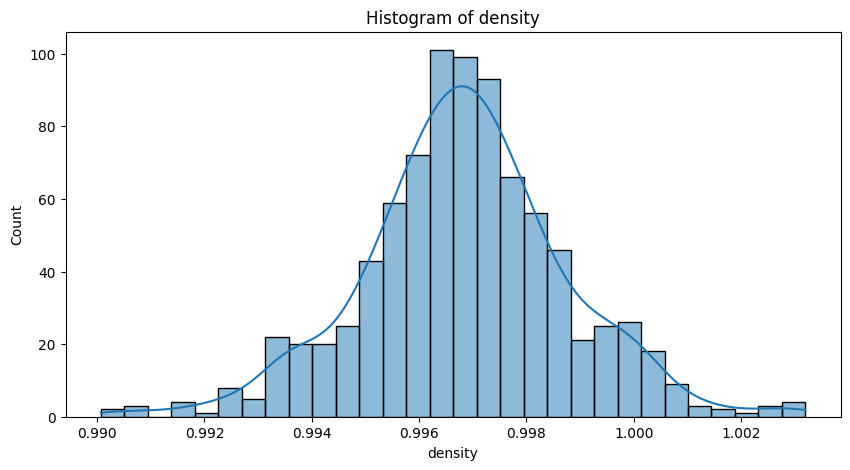

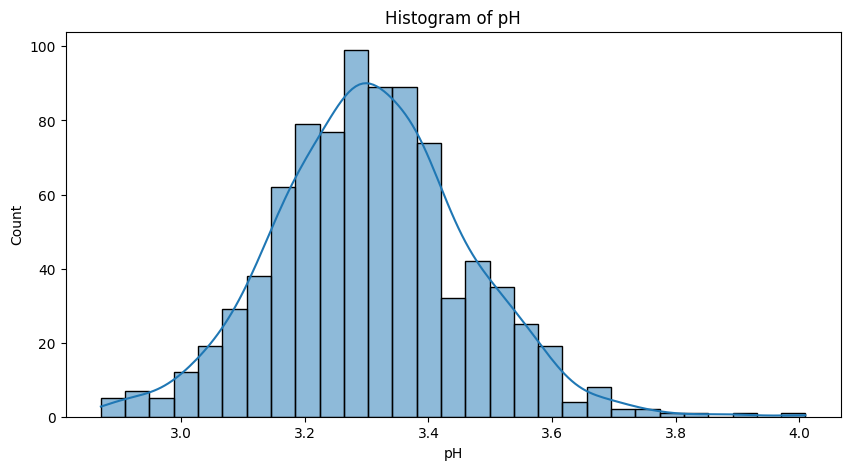

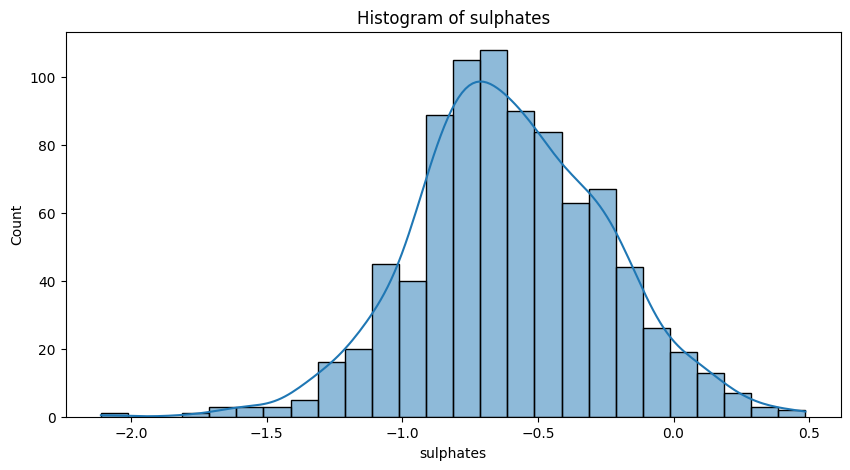

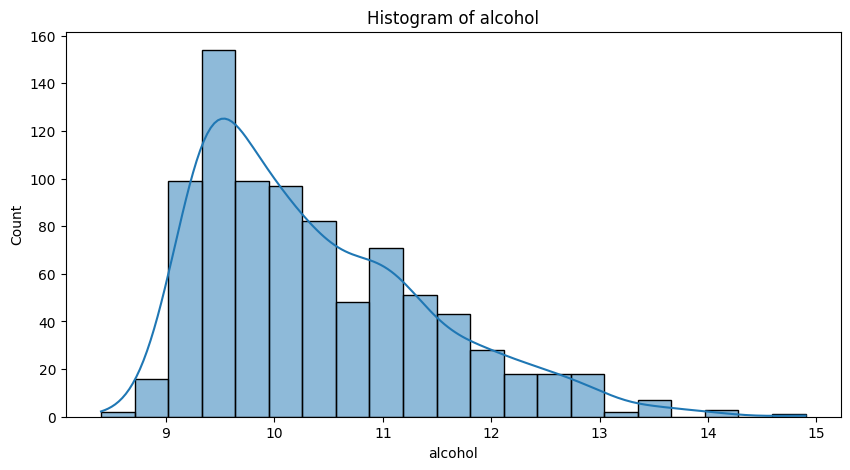

In [258]:
hist_plot(X_train, "Train")

Histplots for Validation data:



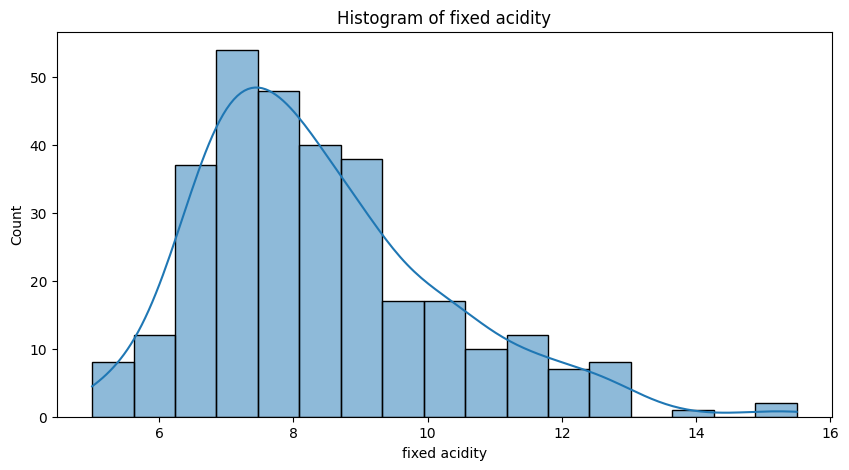

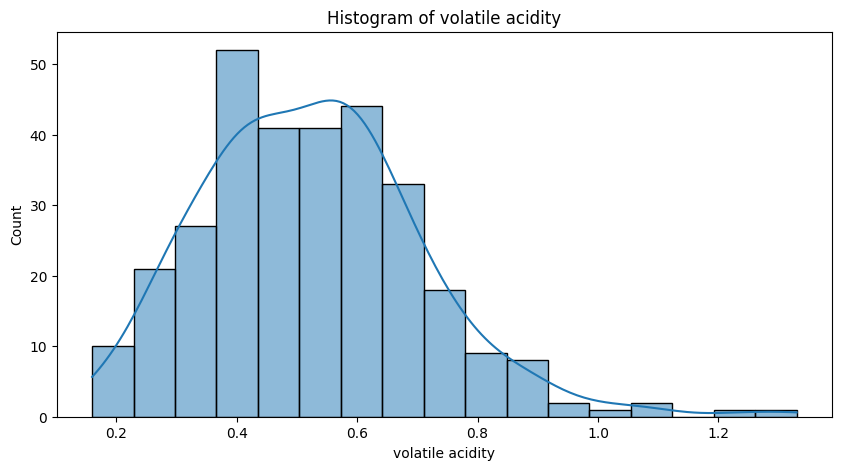

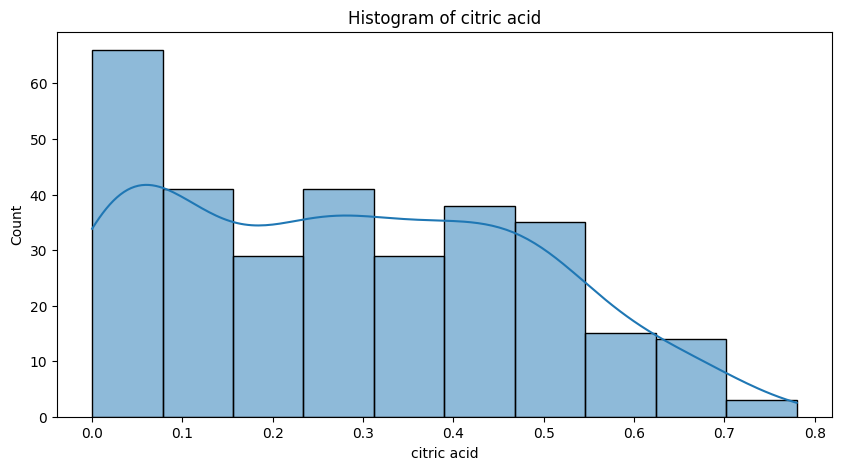

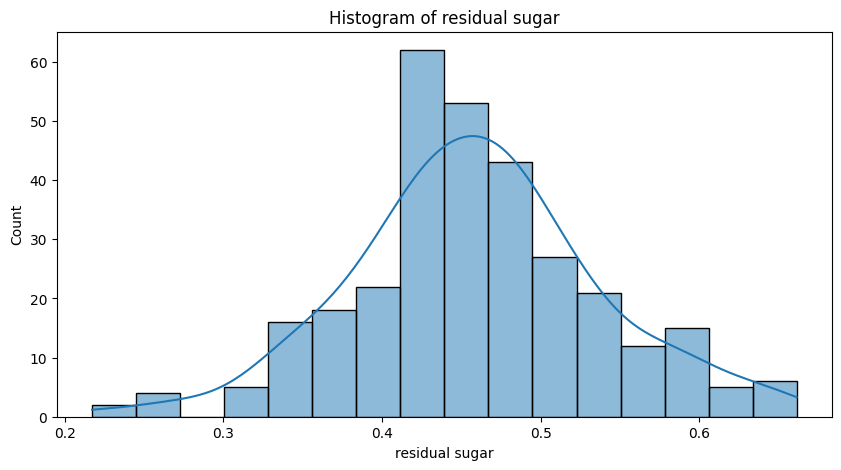

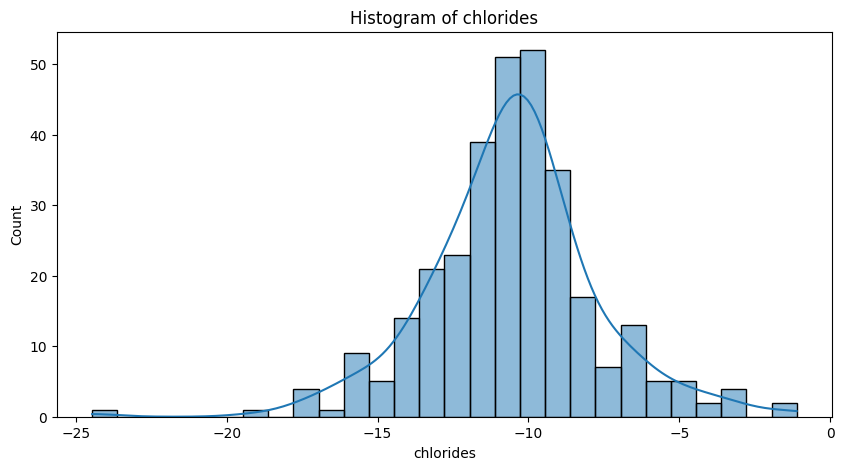

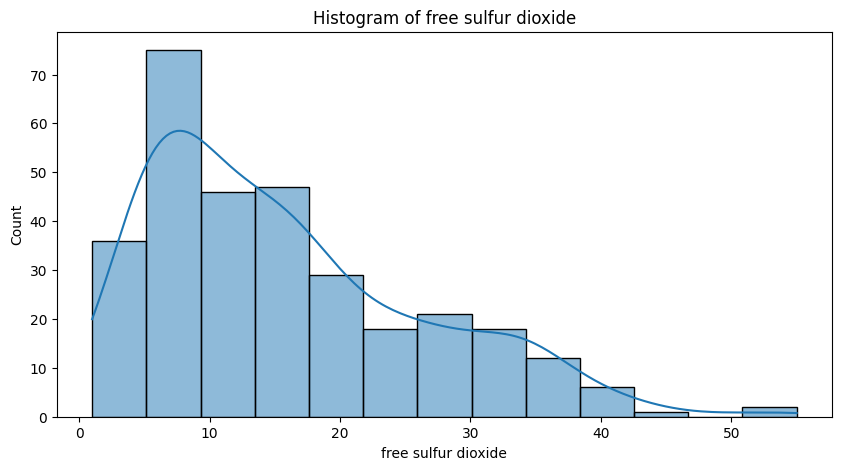

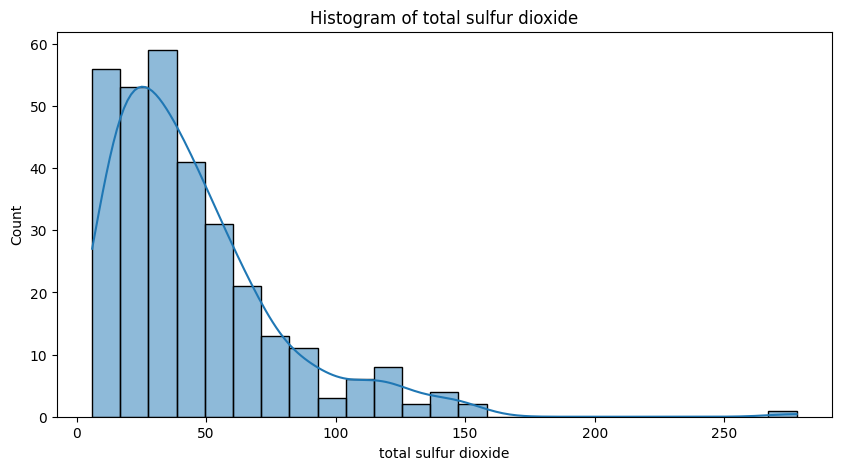

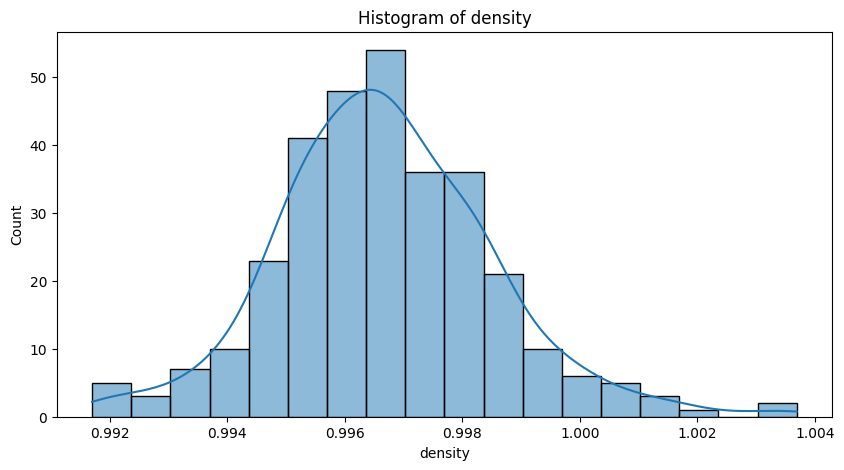

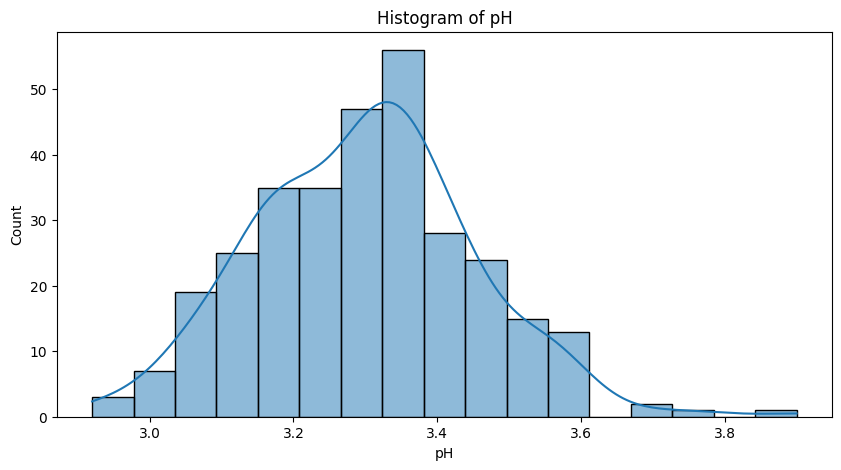

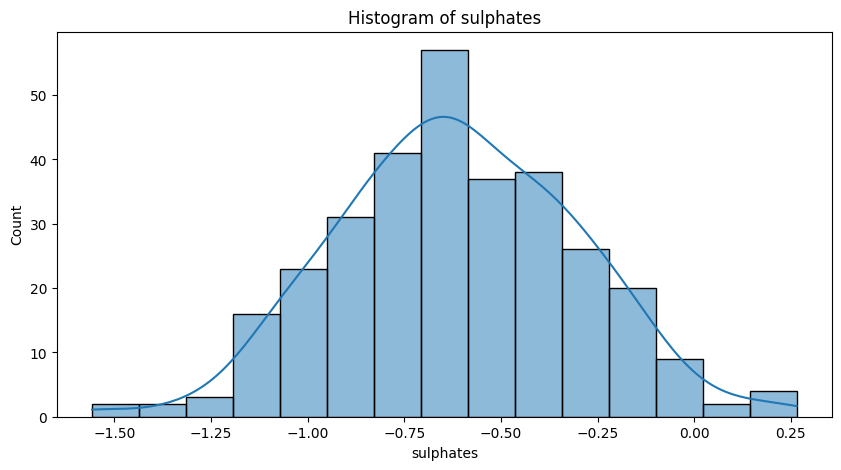

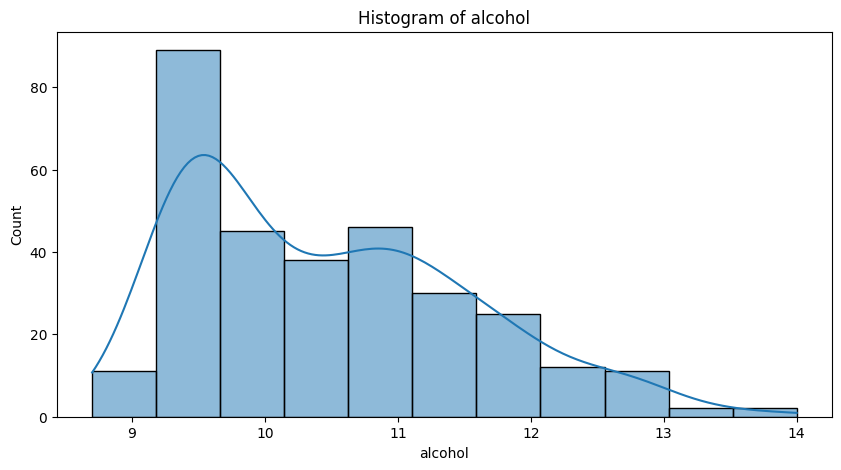

In [259]:
hist_plot(X_valid, "Validation")

Boxplots for Train data:



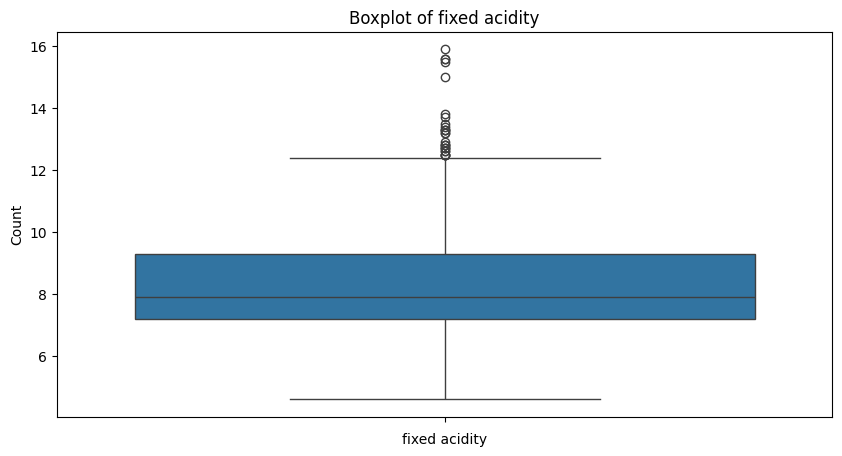

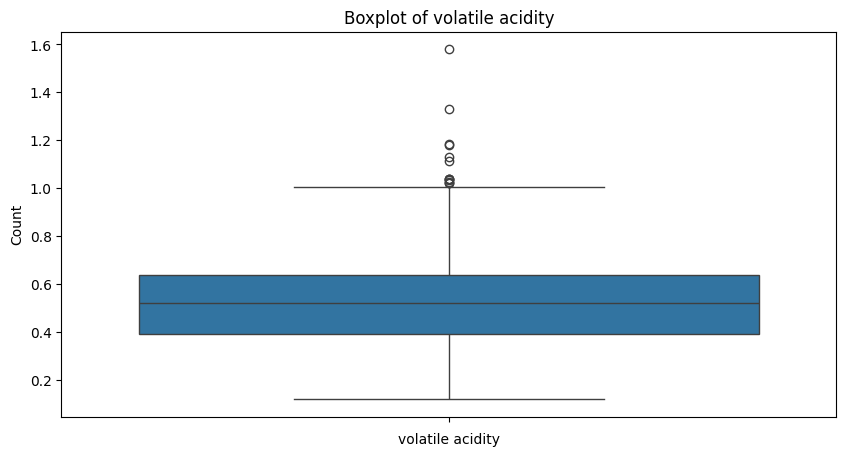

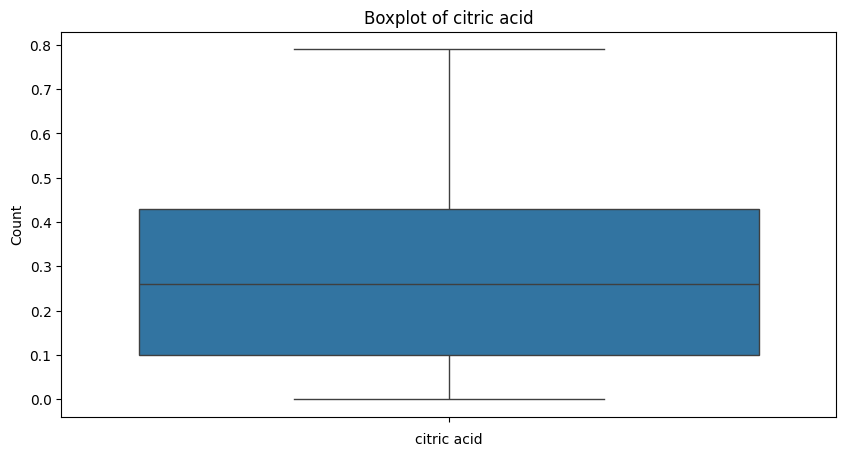

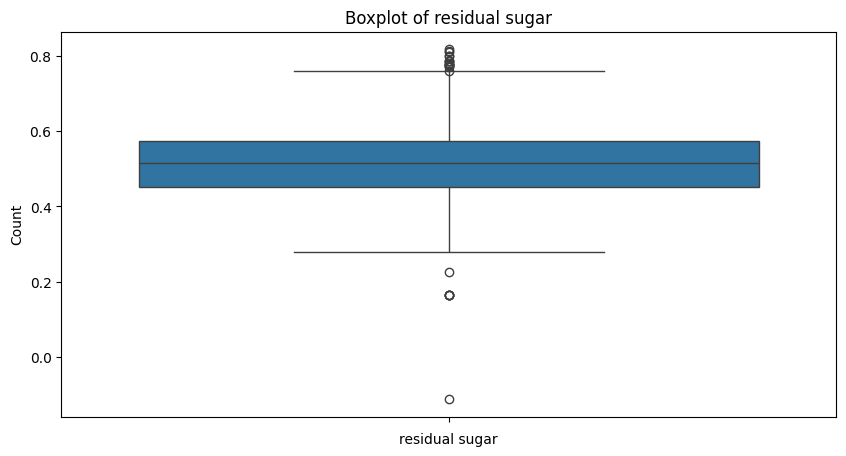

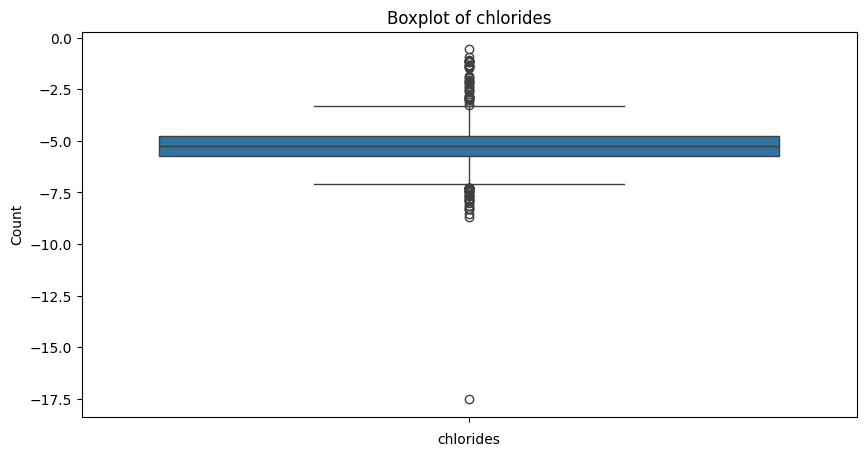

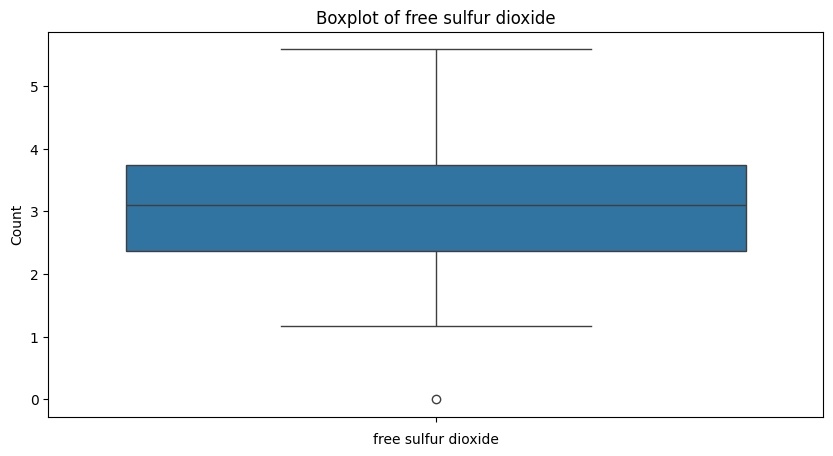

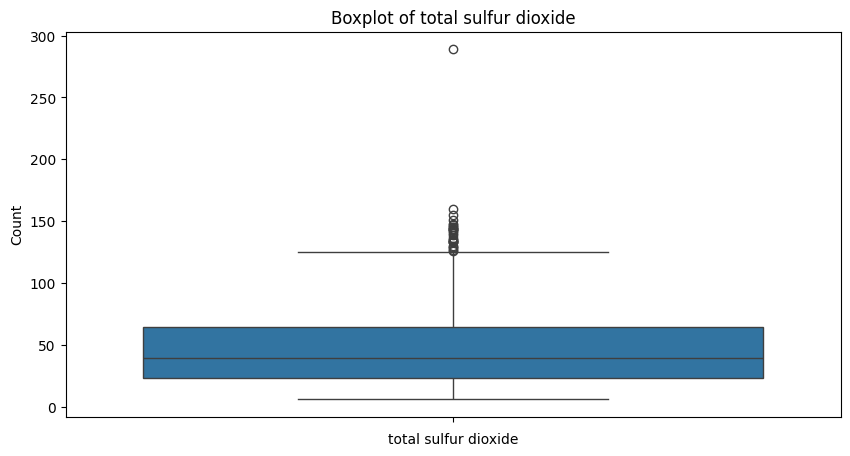

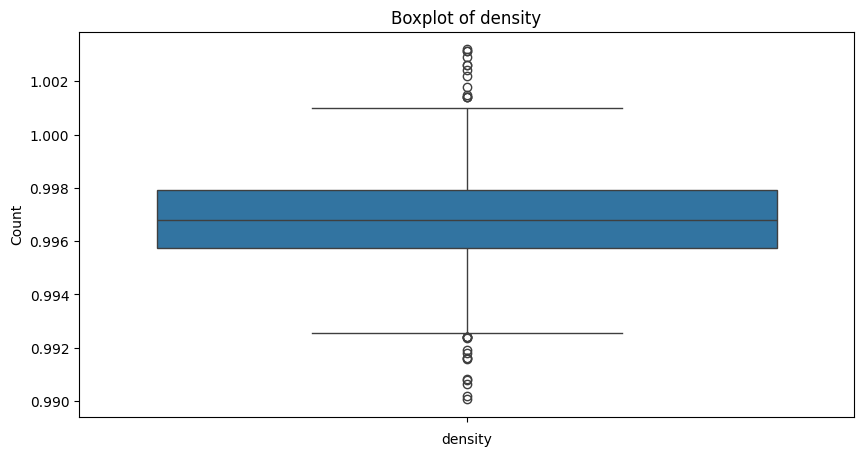

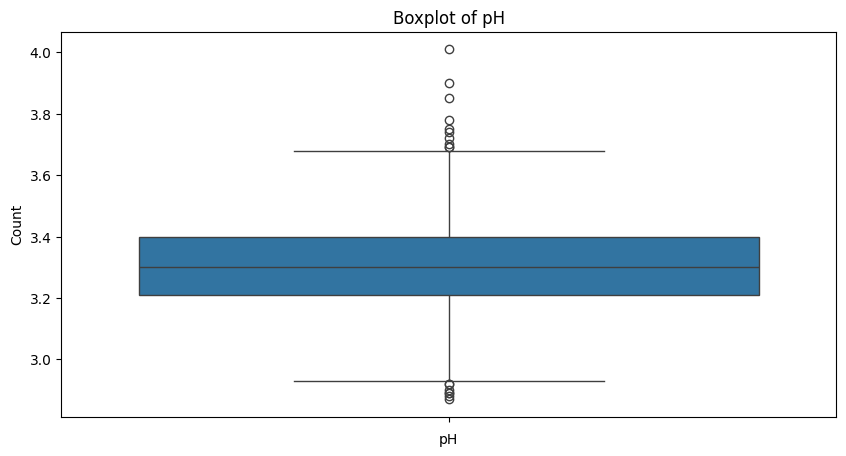

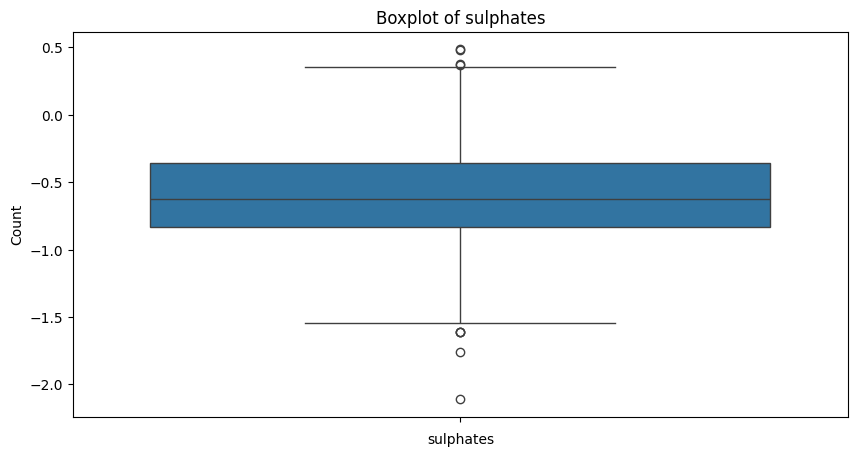

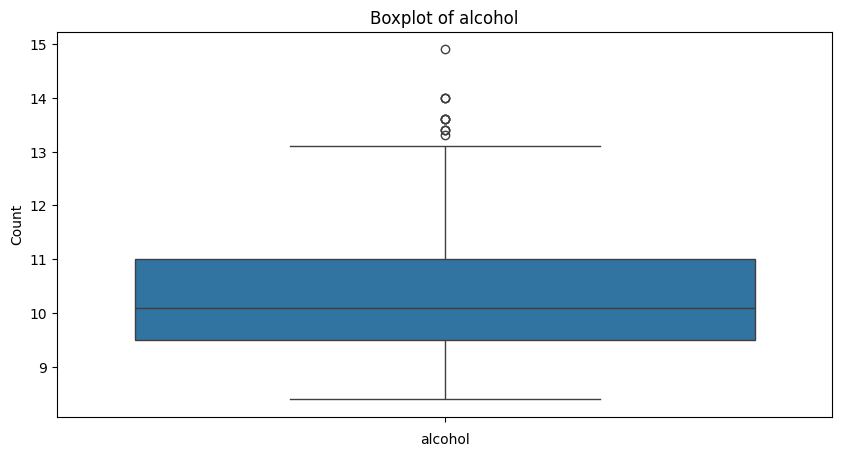

In [260]:
box_plot(X_train, "Train")

Boxplots for Validation data:



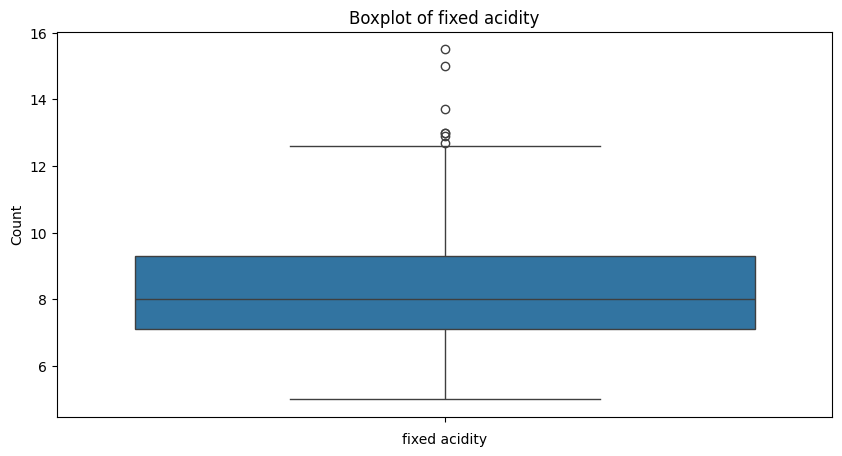

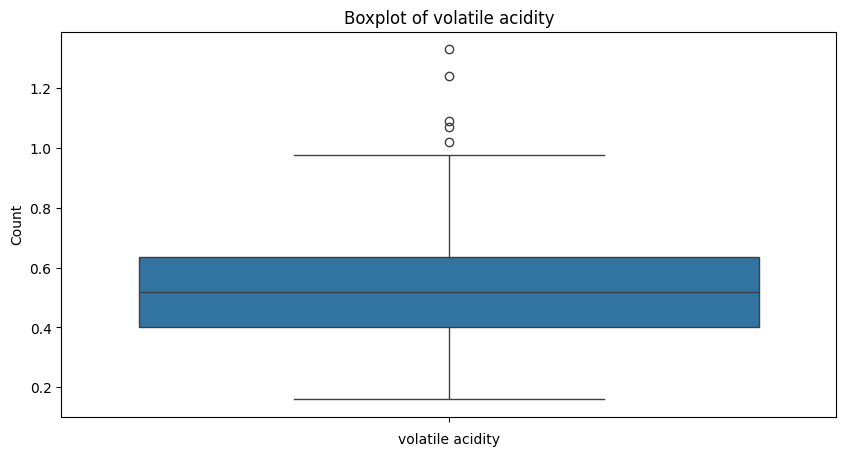

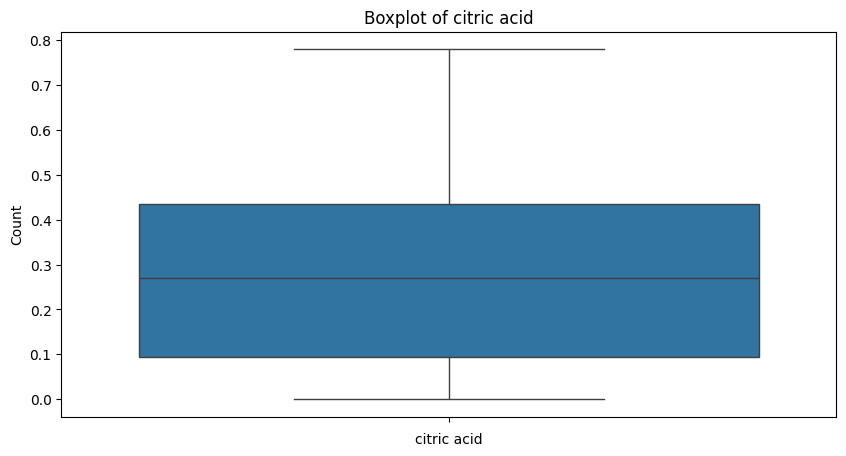

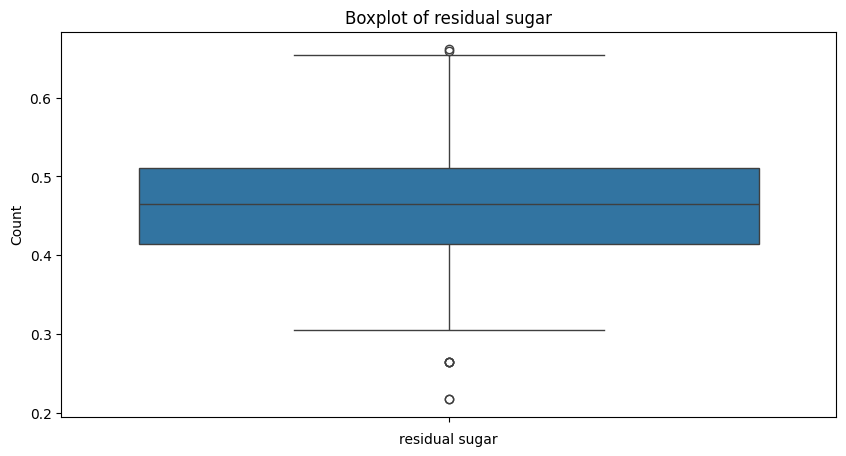

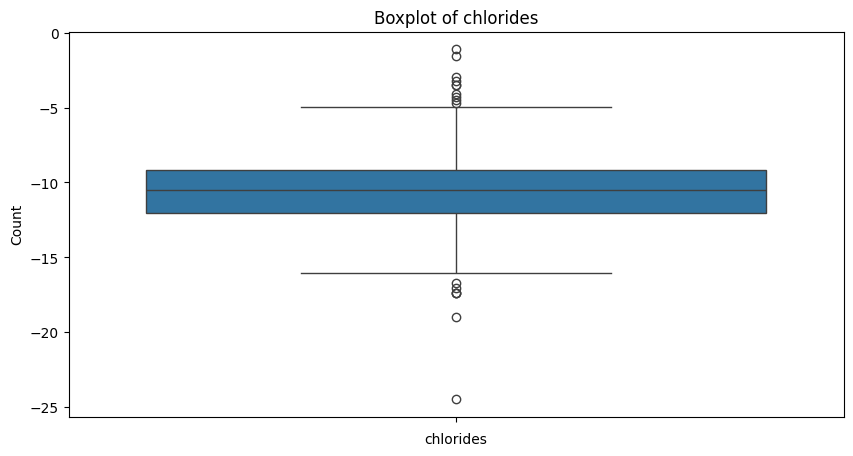

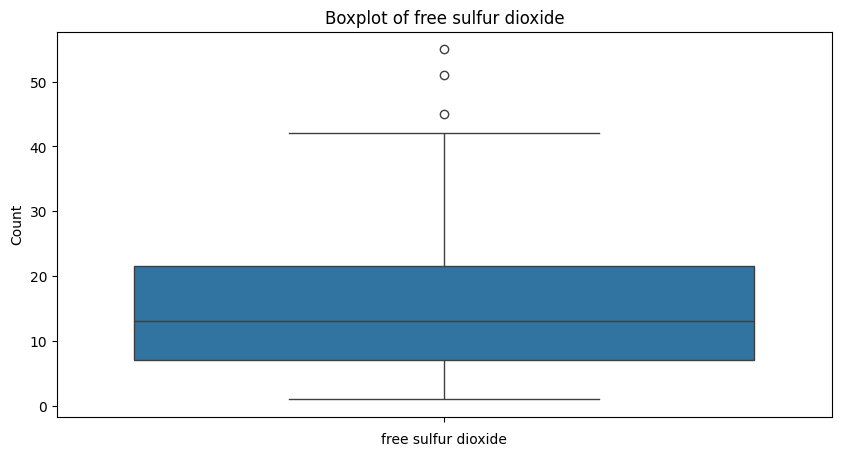

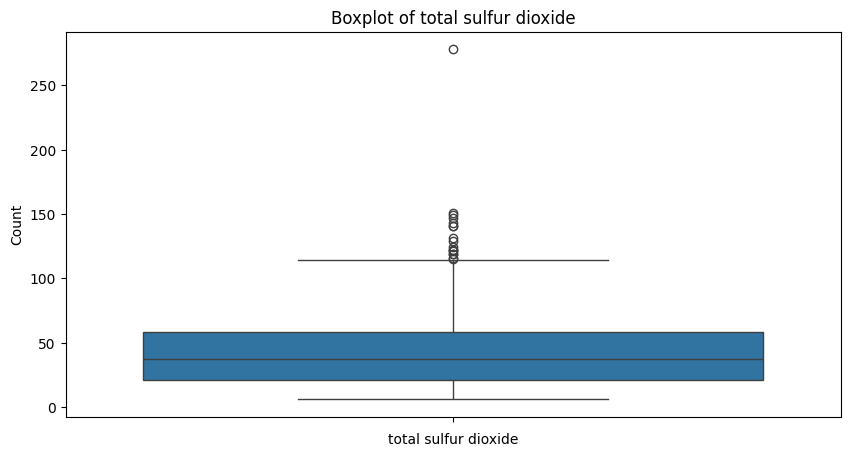

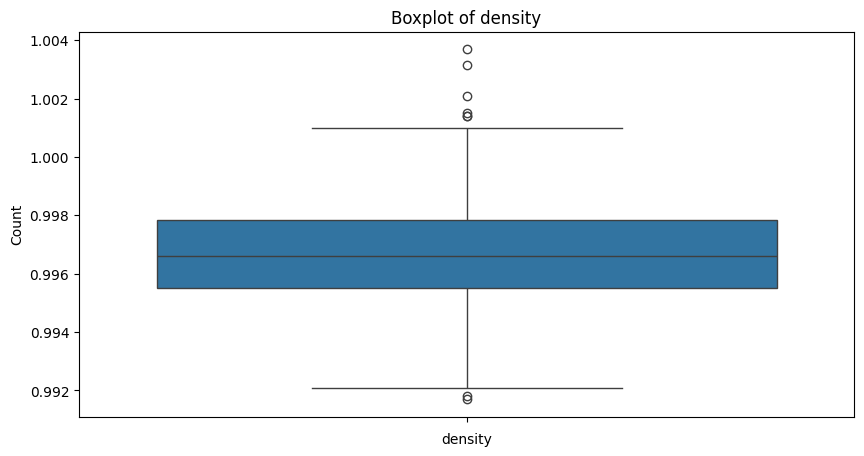

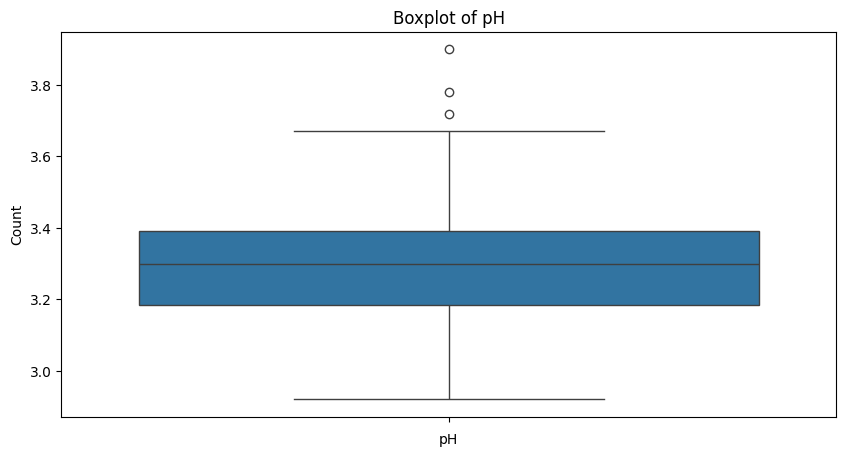

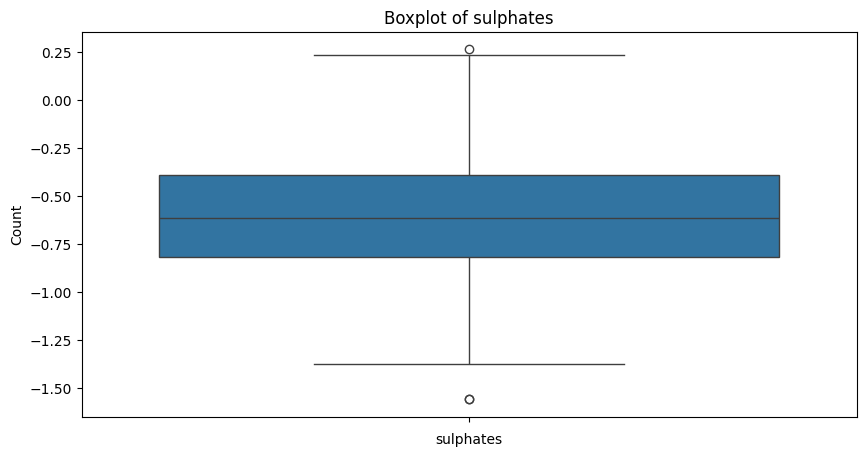

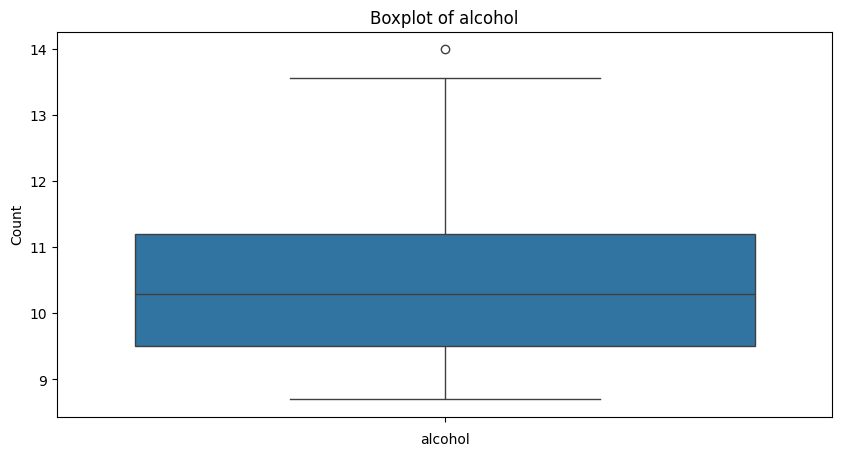

In [261]:
box_plot(X_valid, "Validation")

In [262]:
train_cols = ['fixed acidity', 'volatile acidity', 'density', 'pH', 'chlorides', 'residual sugar']

valid_cols = ['residual sugar', 'chlorides', 'density']

In [263]:
# Replacing the outliers

def impute_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = df[column].median()
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median_value, df[column])
    
    return df

Boxplots for Train data:



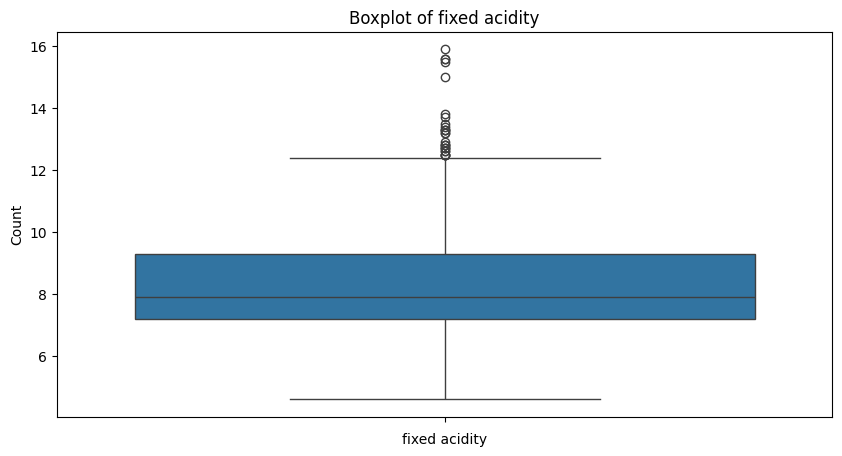

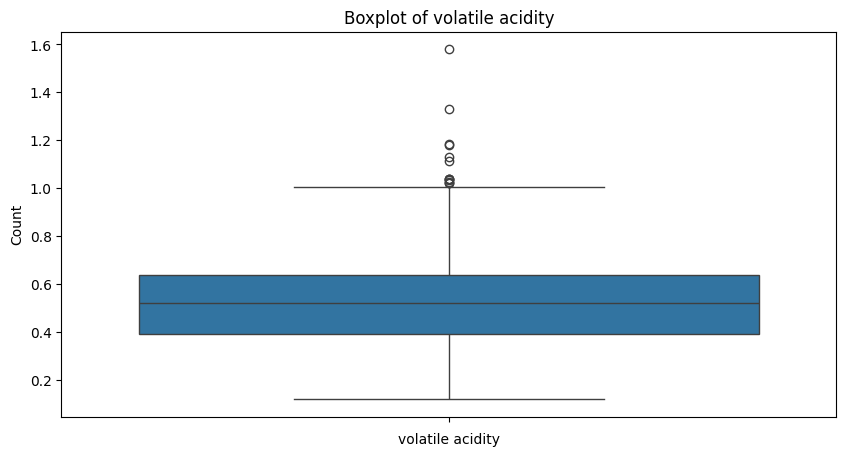

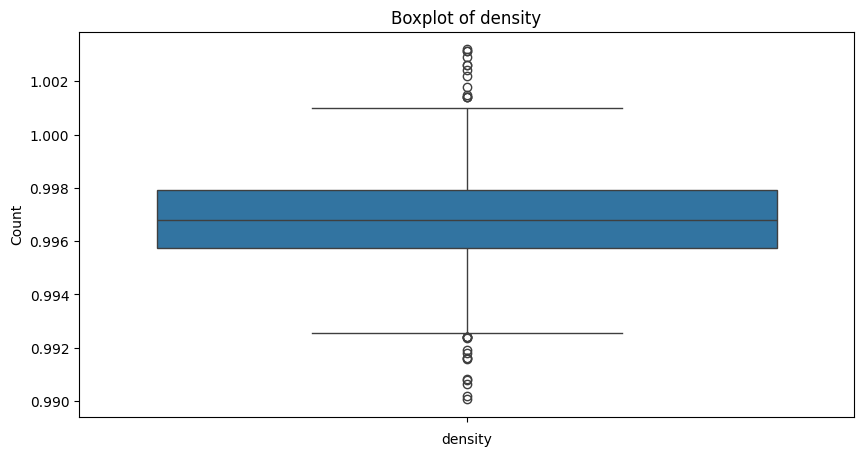

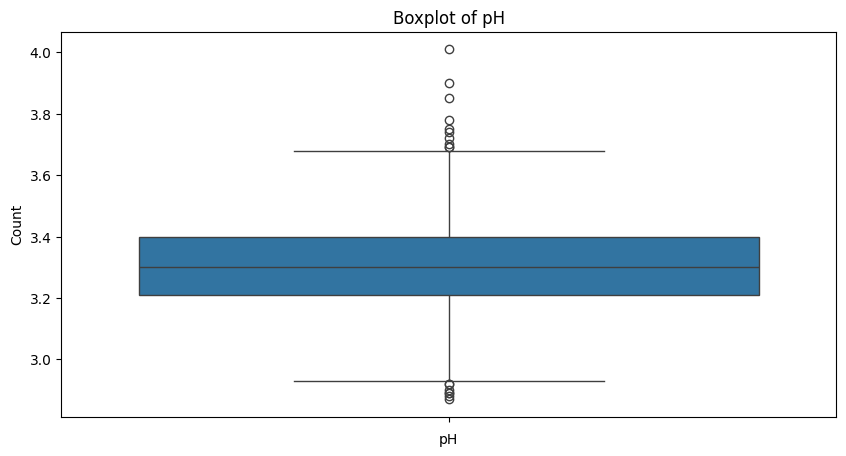

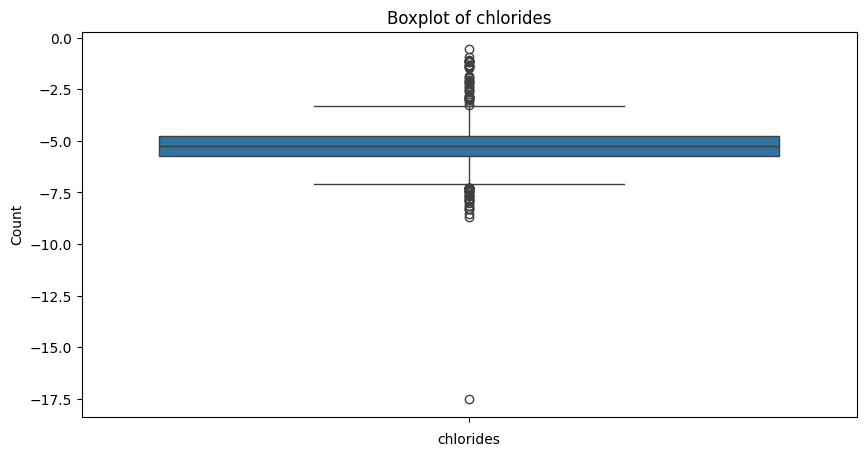

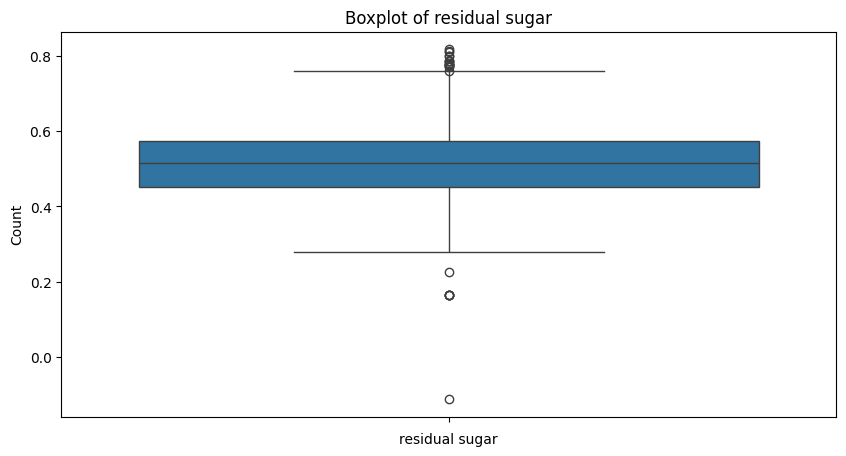

In [264]:
box_plot(X_train[train_cols], "Train")

Boxplots for Validation data:



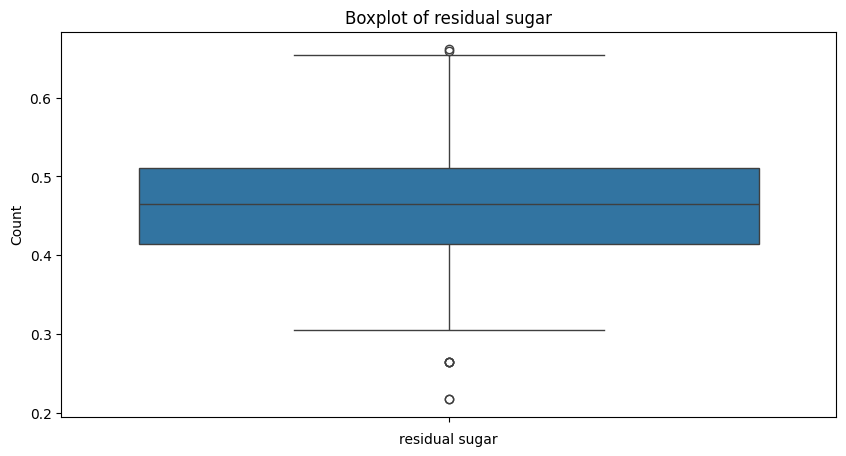

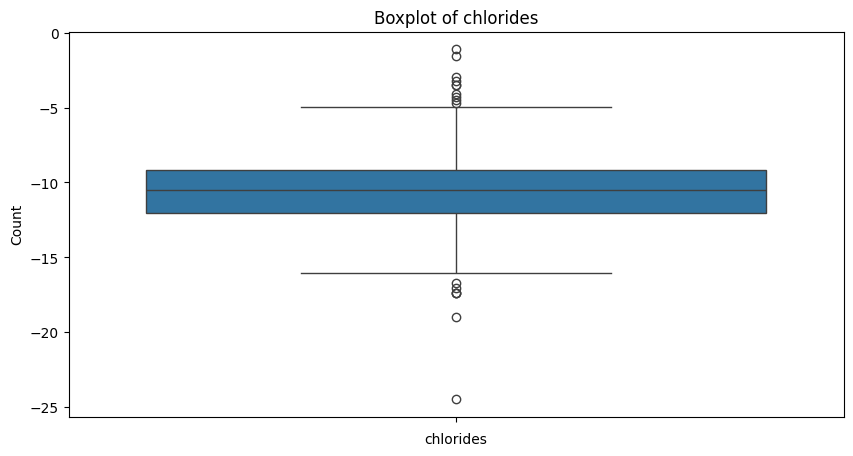

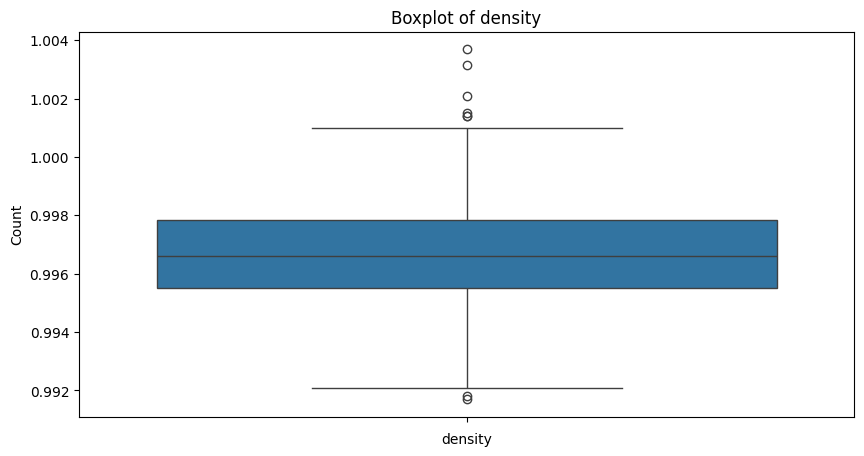

In [265]:
box_plot(X_valid[valid_cols], "Validation")

In [266]:
for col in train_cols:
    X_train = impute_outliers(X_train, col)
    
for col in valid_cols:
    X_valid = impute_outliers(X_valid, col)

In [267]:
X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

Boxplots for Train data:



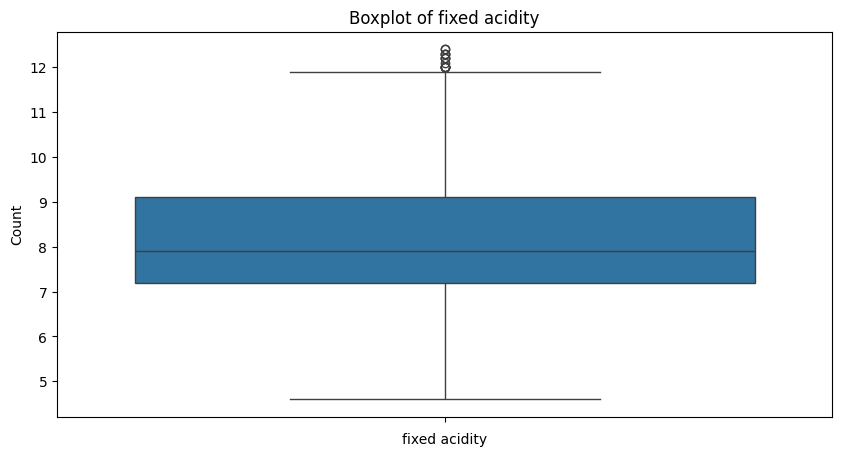

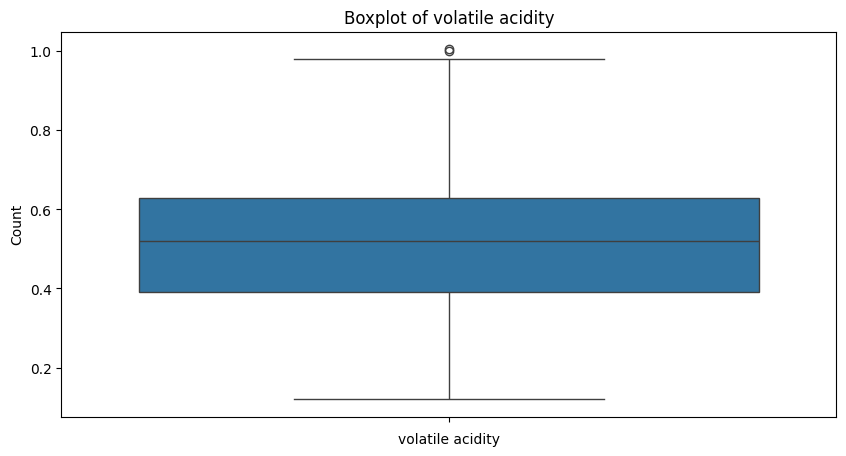

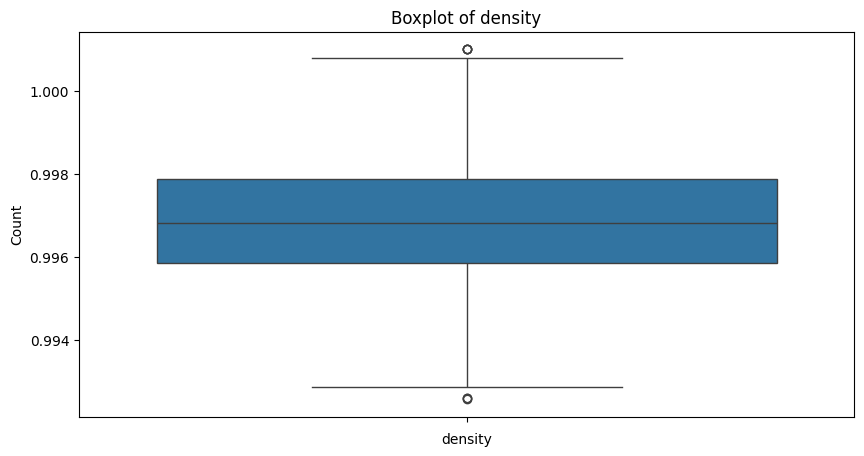

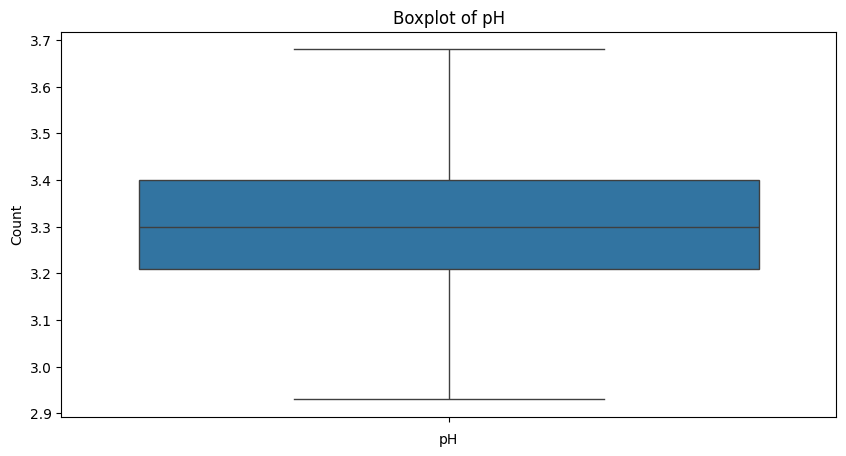

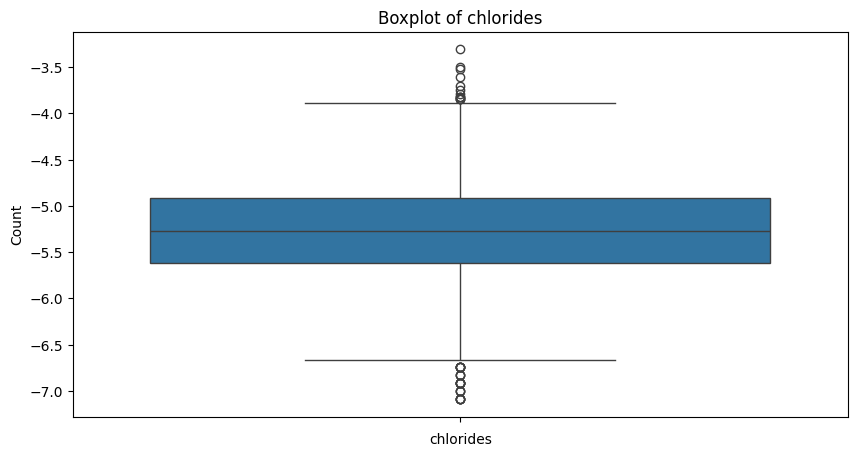

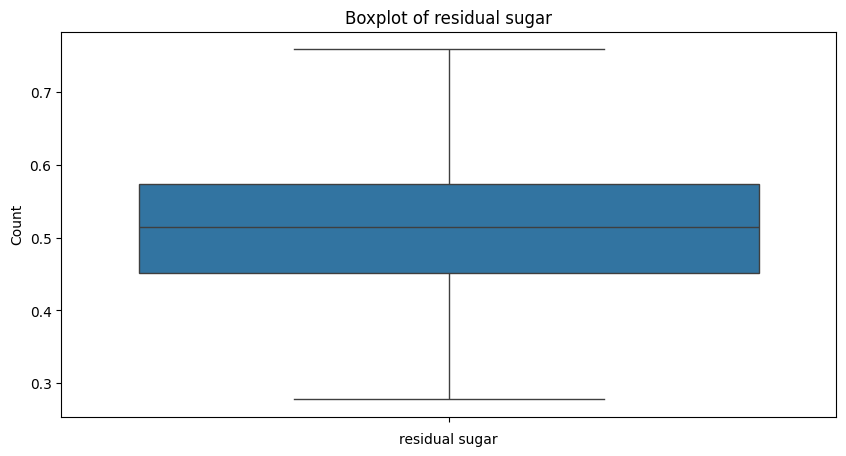

In [268]:
box_plot(X_train[train_cols], "Train")

Boxplots for Validation data:



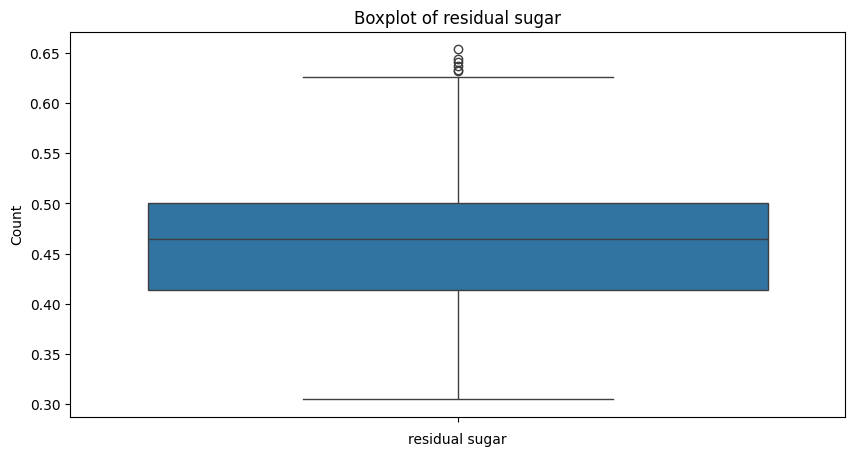

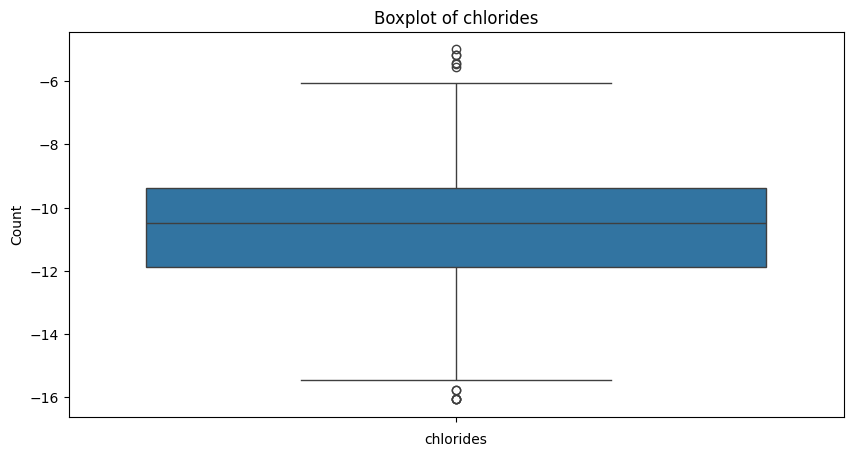

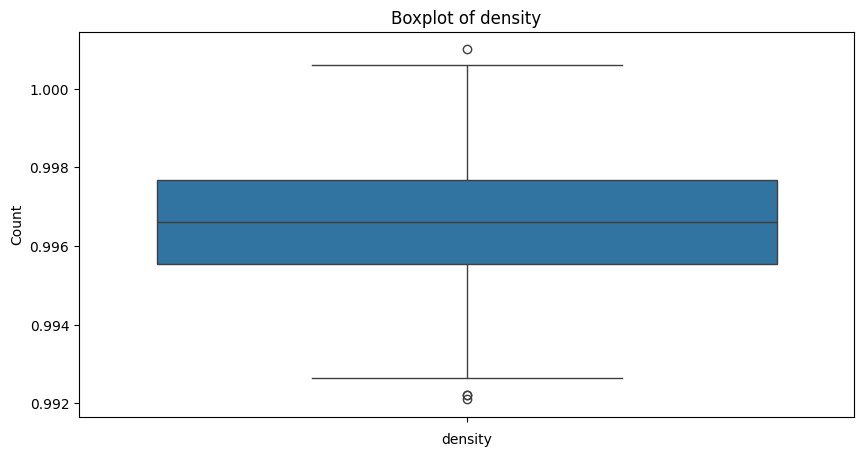

In [269]:
box_plot(X_valid[valid_cols], "Validation")

In [270]:
X_train.skew()

fixed acidity           0.614000
volatile acidity        0.282306
citric acid             0.291973
residual sugar          0.173460
chlorides              -0.154377
free sulfur dioxide    -0.014520
total sulfur dioxide    1.450785
density                 0.018679
pH                      0.035030
sulphates              -0.020647
alcohol                 0.968614
dtype: float64

In [271]:
# Further imputation of outliers
X_train = impute_outliers(X_train, 'chlorides')
X_valid = impute_outliers(X_valid, 'residual sugar')

In [272]:
# Box Plot Check 
a = ['chlorides']
# box_plot(X_train[a], "Train")

In [273]:
b = ['residual sugar']
# box_plot(X_valid[b], "Validation")

In [274]:
# # Standard Scaling the features
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_validation_scaled = scaler.fit_transform(X_valid)

# X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
# X_valid = pd.DataFrame(X_validation_scaled, columns = X_valid.columns)

In [275]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Convert the scaled data back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

In [276]:
# Checking y shapes
print(f"{y_train.value_counts(ascending=True)}\n{y_valid.value_counts(ascending=True)}")

quality
8      5
4     36
7    108
6    341
5    367
Name: count, dtype: int64
quality
3      2
8      6
4     12
7     41
6    109
5    141
Name: count, dtype: int64


In [277]:
# Dropping some features - Improves the model
X_train = X_train.drop(['residual sugar'], axis = 1)
X_valid = X_valid.drop(['residual sugar'], axis = 1)

Here I have handled the models in 2 ways: Using all quality values and by labeling quality values as good or bad.

If binary classification method is allowed, assume the F1 score of that model, else of multi class one.

In [278]:
# Random Forest Classification 
rfc = RandomForestClassifier(n_estimators=100)

y_pred = rfc.fit(X_train, y_train).predict(X_valid)

In [279]:
# Saving model as pickle file
# The files are saved in a Saved_Models Folder
with open('Saved_Models/rfc_model_normal.pkl', 'wb') as file:
    pickle.dump(rfc, file)

print("Model saved as pickle file.")

Model saved as pickle file.


In [280]:
# For evaluation:
# Loading the pickle file 
with open('Saved_Models/rfc_model_normal.pkl', 'rb') as file:
    model = pickle.load(file)

print("Model loaded from pickle file.")
# Evaluate the predictions
metrics = evaluate_classification(y_valid, y_pred)
for metric, value in metrics.items():
    if metric != 'Confusion Matrix':
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}:\n{value}")

Model loaded from pickle file.
Accuracy: 0.5820
Precision: 0.5762
Recall: 0.5820
F1 Score: 0.5678
Confusion Matrix:
[[ 0  1  1  0  0  0]
 [ 0  0  9  3  0  0]
 [ 0  0 89 50  2  0]
 [ 0  3 24 76  6  0]
 [ 0  0  1 24 16  0]
 [ 0  0  0  4  2  0]]


c:\Users\quinj\Documents\Wine-Quality-Classification\machinelearning\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [281]:
# Labeling the quality based on value counts, this is done for binary classification
y_train.replace([4,5], 'bad', inplace = True)
y_train.replace([6,7,8], 'good', inplace = True)

y_valid.replace([4,5], 'bad', inplace = True)
y_valid.replace([6,7,8], 'good', inplace = True)

In [282]:
y_valid.head()

0    good
1    good
2    good
3     bad
4    good
Name: quality, dtype: object

In [283]:
# Random Forest Classification 
rfc = RandomForestClassifier(n_estimators=50, random_state=0)

# Using cross validation
f1_scores = cross_val_score(rfc, X_train, y_train, cv=20, scoring='f1_macro')

# Fitting the model
rfc.fit(X_train, y_train)

# Predicting values
y_pred = rfc.predict(X_valid)

y_pred = pd.DataFrame(y_pred)
# Calculate the F1 Score
f1 = f1_score(y_valid, y_pred, average='macro')

print(f"F1_Score: {f1:.4f}")

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
# Saving model as pickle file
with open('Saved_Models/rfc_model_binary.pkl', 'wb') as file:
    pickle.dump(rfc, file)

print("Model saved as pickle file.")

Model saved as pickle file.


In [ ]:
# For evaluation:

# Loading the pickle file 
with open('Saved_Models/rfc_model_binary.pkl', 'rb') as file:
    model = pickle.load(file)

print("Model loaded from pickle file.")

# Evaluate the predictions
metrics = evaluate_classification(y_valid, y_pred)
for metric, value in metrics.items():
    if metric != 'Confusion Matrix':
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}:\n{value}")

Model loaded from pickle file.
Accuracy: 0.7739
Precision: 0.7807
Recall: 0.7739
F1 Score: 0.7745
Confusion Matrix:
[[115  26]
 [ 45 128]]
